# When Will You Die In PLAYERUNKNOWN'S BATTLEGROUNDS?

## What is PLAYERUNKNOWN'S BATTLEGROUNDS?

PLAYERUNKNOWN'S BATTLEGROUNDS, aka PUBG, is a Battle Royale online game with an enormous player community. A battle royale game has typically 100 players in an arena with weapons and items scattered throughout the arena, where players drop into the map and try to gether loot in order to outlive everybody else. Throughout any given match, the playable map size also decreases as the game progresses in order to force remaining players to kill each other in order to create a winner. This is done by making zones on the map that will slowly get smaller and smaller until the entire map is covered. The outside zone, called the blue zone in the dataset, will damage players more and more as each playable zone decreases in size, and will eventually kill someone that is stuck in the blue zone.

## Problem

A game needs it playerbase to derive a form of fun from it in order to capture a player's devotion to it. Especially in an online game, it requires this factor even moreso since the online gaming market is so competitive, without a reason for players to keep playing one game, they can easily move onto the next game. Therefore, the question of how much excitement and action is there at different points in the match, and how can that be measured? One way is to create a model for the survival time of a player in a match. The number of players that die within a certain amount of time would show how many players are meeting and fighting each other, which would directly show levels of interaction between players and also indirectly their enjoyment of the game. 

## Client

The game development studio, PUBG Corporation can use this analysis to see how players are enjoying the game and if any improvements can be made in order to increase their playerbase, as well as to keep the current playerbase happy enough to keep playing. They could use this model as a base to measure different components of the game such as trends of players that make it to the late game versus players that die early in the game. This information can be very valuable because it will show what percentage of players prefer to fight as soon as possible, which requires areas of high density of weapons and items, or players that prefer to try to survive as long as possible and scavenge across the map, and all the players in between. These percentages would show the community's prefferred playstyle and the company can adjust the game accordingly, whether it is to make the early game more exciting or entice players to want to survive instead and reach late game.

Another possible client would be other game development studios that want to create or change their own battle royale game. Knowing what their competitors are doing right or maybe wrong would give the studio an idea of how to fix or make their game in order to attract new players while also keeping their current playerbase satisfied with their product.

## Data Wrangling Process

First thing done after loading in each dataset was I joined the datasets together. Then, only rows that contained the map name Erangel in the map column was kept. Also, in order to remove any outliers, any rows where the timer value was bigger than 2000 seconds was removed, since a match can only last for about 2000 seconds before the blue zone covers the entire map and kills all remaining players. I took the number of unique match_id and replaced the column of strings into a column of integers from zero to the number of unique matches in the data. A new column was made in the dataset that seperated rows by their team placement, seperated by the tens place, and labeled target_10_bins. Averages of survival times were than calculated and plotted by the new column.

In [1]:
import os

mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-8.1.0-posix-seh-rt_v6-rev0\\mingw64\\bin'

os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import matplotlib as mpl
import seaborn as sns
import findspark
findspark.init()
import pyspark
import xgboost as xgb

## Data Import and Preparation

In [3]:
d = pd.read_csv('agg_match_stats_0.csv')
e = pd.read_csv('agg_match_stats_1.csv')
a = pd.read_csv('agg_match_stats_2.csv')
t = pd.read_csv('agg_match_stats_3.csv')
h = pd.read_csv('agg_match_stats_4.csv')
x = pd.concat([d,e,a,t,h])
#d=d[d.party_size==1]
f = x[['game_size','match_mode','party_size','player_survive_time','team_placement','match_id','player_kills','player_dmg'
      ,'player_dist_ride','player_dist_walk','player_dbno','player_assists']]
f['match_id'].astype(str)
f = f[f.party_size == 1]
f = f[f.player_survive_time <= 2000]
f.reset_index()
print(x.info())
print(f)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67369231 entries, 0 to 11993484
Data columns (total 15 columns):
date                   object
game_size              int64
match_id               object
match_mode             object
party_size             int64
player_assists         int64
player_dbno            int64
player_dist_ride       float64
player_dist_walk       float64
player_dmg             int64
player_kills           int64
player_name            object
player_survive_time    float64
team_id                int64
team_placement         int64
dtypes: float64(3), int64(8), object(4)
memory usage: 8.0+ GB
None
          game_size match_mode  party_size  player_survive_time  \
494              91        tpp           1              186.999   
495              91        tpp           1              124.782   
496              91        tpp           1              839.161   
497              91        tpp           1              751.716   
498              91        tpp        

### Created new columns to categorize the data better

In [4]:
f['win'] = f.team_placement == 1

In [5]:
f['target_perc'] = f.team_placement / f.game_size
 

In [6]:
def dec(perc):
#     perc = f.team_placement / f.game_size
    if perc <= 0.1 and perc >= 0:
        return 1
    elif perc <= 0.2 and perc > 0.1:
        return 2
    elif perc <= 0.3 and perc > 0.2:
        return 3
    elif perc <= 0.4 and perc > 0.3:
        return 4
    elif perc <= 0.5 and perc > 0.4:
        return 5
    elif perc <= 0.6 and perc > 0.5:
        return 6
    elif perc <= 0.7 and perc > 0.6:
        return 7
    elif perc <= 0.8 and perc > 0.7:
        return 8
    elif perc <= 0.9 and perc > 0.8:
        return 9
    else:
        return 10

f['target_10_bins'] = f.target_perc.apply(dec)

In [7]:
f.target_10_bins.unique()

array([ 9, 10,  4,  6,  8,  7,  3,  1,  5,  2], dtype=int64)

Changed match_id column from strings to integers from range of 0 to number of unique strings.

In [8]:
len(f.match_id.unique())

152738

In [9]:
f['match_id'] = pd.factorize(f.match_id)[0]
f['match_id'] = f['match_id'].astype('category')
f.match_id

494              0
495              0
496              0
497              0
498              0
499              0
500              0
501              0
502              0
503              0
504              0
505              0
506              0
507              0
508              0
509              0
510              0
511              0
512              0
513              0
514              0
515              0
516              0
517              0
518              0
519              0
520              0
521              0
522              0
523              0
             ...  
11993185    152737
11993186    152737
11993187    152737
11993188    152737
11993189    152737
11993190    152737
11993191    152737
11993192    152737
11993193    152737
11993194    152737
11993195    152737
11993196    152737
11993197    152737
11993198    152737
11993199    152737
11993200    152737
11993201    152737
11993202    152737
11993203    152737
11993204    152737
11993205    152737
11993206    

### New datasets for the purpose of visualizations of the data

In [8]:
g = f.groupby('team_placement').player_survive_time.mean()
print(g)
i = f.groupby('match_id').player_survive_time.mean()
i = i[i <= 1000]
print(i.head())
k = f.groupby('team_placement').count()
# cake = f.groupby('match_id')

team_placement
1      1873.380034
2      1873.616051
3      1824.144466
4      1771.736636
5      1726.883338
6      1687.472575
7      1651.834665
8      1618.792180
9      1587.629970
10     1557.806085
11     1529.058968
12     1501.388448
13     1474.521495
14     1447.740803
15     1420.775116
16     1393.265046
17     1365.112949
18     1336.608056
19     1307.728003
20     1278.637713
21     1249.605479
22     1220.109384
23     1190.887350
24     1162.029637
25     1133.223595
26     1104.696852
27     1076.494001
28     1048.914846
29     1021.821273
30      995.369153
          ...     
71      232.297500
72      224.214715
73      216.799286
74      209.370795
75      202.075120
76      196.589349
77      189.959889
78      183.447579
79      178.508893
80      172.894102
81      168.236689
82      164.173696
83      161.109409
84      156.885502
85      152.869309
86      150.659238
87      149.085319
88      147.300016
89      147.130713
90      146.301677
91      148.8499

In [15]:
l = f.groupby('target_10_bins').mean()
print(l.player_survive_time)
print(l.player_kills)
print(l.player_dist_walk)

target_10_bins
1     1736.864586
2     1451.041848
3     1188.683407
4      937.479399
5      704.716038
6      507.575186
7      352.559185
8      247.868652
9      176.005199
10     156.555069
Name: player_survive_time, dtype: float64
target_10_bins
1     3.036486
2     1.555882
3     1.159274
4     0.936289
5     0.772259
6     0.627745
7     0.498752
8     0.375107
9     0.240313
10    0.071480
Name: player_kills, dtype: float64
target_10_bins
1     2839.140044
2     2559.175421
3     2104.835422
4     1669.247341
5     1334.881967
6      789.420326
7      416.685280
8      229.941387
9      115.080039
10      39.610521
Name: player_dist_walk, dtype: float64


In [14]:
f['walk_per_100'] = f.player_dist_walk / 100
f['walk_per_100'].head()

494     1.709548
495     0.665456
496     6.101689
497    14.312920
498     7.231023
Name: walk_per_100, dtype: float64

## Data Visualizations and Analysis

This histogram shows the probability of death in a match using the data from all matches in the dataset

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


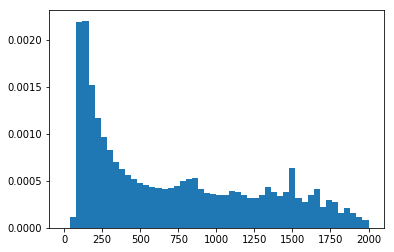

In [16]:
plt.hist(f.player_survive_time,bins=50,normed=True)
plt.show()

I checked how many unique matches were in the dataset and then changed the column from strings into a range of integers

The probability of dying is highest in the first 5 minutes than at any other time in the game. This is most likely due to players that fall down into areas of the game that have high player concentrations and fight and most likely die as a result.

Text(0.5,1,'Average Player Kills')

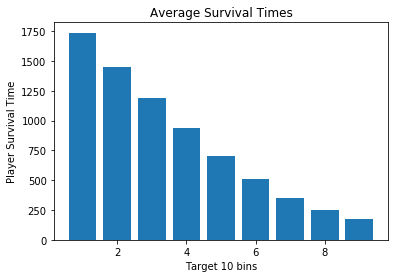

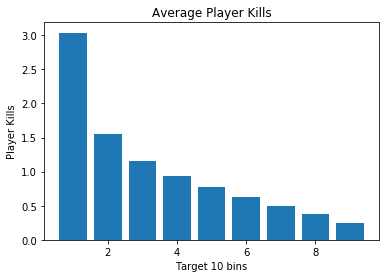

In [17]:
plt.figure()
plt.bar([1,2,3,4,5,6,7,8,9],l.player_survive_time[0:9])
plt.ylabel('Player Survival Time')
plt.xlabel('Target 10 bins')
plt.title('Average Survival Times')
plt.figure()
plt.bar([1,2,3,4,5,6,7,8,9],l.player_kills[0:9])
plt.xlabel('Target 10 bins')
plt.ylabel('Player Kills')
plt.title('Average Player Kills')

These graphs show that players that survive longer, both tend to place higher and also have killed more players on average. This relationship of higher average kills with increased survival time makes the most sense since if a player kills another player, then that means that he has survived that much longer than another player, increasing his potential survival time and also his rank within the match.

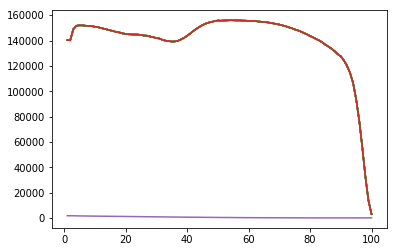

In [18]:
plt.plot(k)
plt.plot(g)

The average time a player is alive is higher as his team placement gets closer to one, which makes sense considering that whoever wins has outlived all other players in their match which gives him team placement of one. However, looking at the count and mean graph shows some irregularity towards the right hand side of the graph. The number of teams that place close to 100 are significantly less than teams that place higher. And also the average survival time of teams close to 100 are higher than what would be expected considering the trend of the rest of the means. This irregularity in the count can be understood if party size column is observed. Since we are looking at games that are not exclusively solo players, party size equal to one, this means that the number of teams in a match can be much less than 100 since only 100 players can be in any given match and party size in a match can differ.

### Made a histogram of the average survival time in a given match along with the normal curve given its mean and standard deviation

In [19]:
mu = np.mean(i)
sigma = np.std(i)
fit = norm.pdf(i,np.mean(i),np.std(i))
print(mu,sigma)

722.1725303739164 65.85585274740606


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


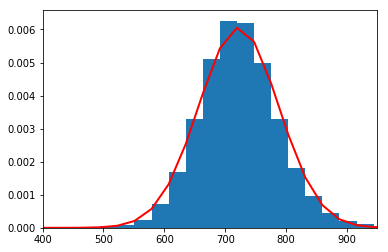

In [20]:
count, bins, ignored = plt.hist(i,bins=30,normed=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')
plt.xlim(400,950)
plt.show()

This graph shows the distribution of the average survival time in any given match and its probability. The distribution seems to closely follow the curve of the normal distribution given its standard deviation and mean, and the mean is at about 722.2 seconds, with a standard deviation of 65.86 seconds.

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:

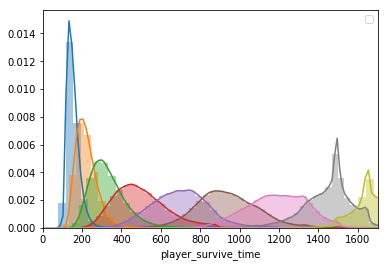

In [21]:

sns.distplot(f[f.target_10_bins == 9].player_survive_time)
plt.xlim(0,500)

sns.distplot(f[f.target_10_bins == 8].player_survive_time)
plt.xlim(0,750)

sns.distplot(f[f.target_10_bins == 7].player_survive_time)
plt.xlim(0,1000)

sns.distplot(f[f.target_10_bins == 6].player_survive_time)
plt.xlim(0,1000)

sns.distplot(f[f.target_10_bins == 5].player_survive_time)
plt.xlim(0,1500)

sns.distplot(f[f.target_10_bins == 4].player_survive_time)
plt.xlim(0,1700)

sns.distplot(f[f.target_10_bins == 3].player_survive_time)

sns.distplot(f[f.target_10_bins == 2].player_survive_time)

sns.distplot(f[f.target_10_bins == 1].player_survive_time)
plt.legend()


The death timer distributions, from left to right, are for target_10_bins from 9 to 1. The distributions for bins 9 and 8 both overlap each other and 8's peak has its peak almost touching 9's distribution. But further right, the distributions for each bin become more spread out and also look relatively normal until the 3rd bin. That is where the curves start to look very irregular, which tells that the last 2 bins, or the last 20 players alive in a match, have death times that are not as evenly spread out and are more sporadic. Since the lategame of a match has such a few nuber of players and the playstyle changes as a result, this type of distribution makes sense.

## Model Building

Made a draft dataset, called data, with columns that looked interesting for building a model to predict survival times then made a new dataset off of data dataset with only columns that were going to go into the linear regression model as its independent variables.

In [10]:

data = f[['player_survive_time','team_placement','match_id','player_kills','player_dmg','player_dist_ride','player_dist_walk',
         'player_dbno','player_assists','win','target_perc','target_10_bins']]
data.head(10)

,player_survive_time,team_placement,match_id,player_kills,player_dmg,player_dist_ride,player_dist_walk,player_dbno,player_assists,win,target_perc,target_10_bins
494,186.999,79,0,0,0,0.000000,170.954788,0,0,False,0.868132,9
495,124.782,87,0,0,0,0.000000,66.545590,0,0,False,0.956044,10
496,839.161,35,0,0,124,728.722656,610.168945,0,0,False,0.384615,4
497,751.716,46,0,0,24,2646.184000,1431.292000,0,0,False,0.505495,6
498,744.088,47,0,1,100,0.000000,723.102300,0,0,False,0.516484,6
499,108.231,90,0,0,0,0.000000,0.000000,0,0,False,0.989011,10
500,1006.527,29,0,4,438,1055.677610,1889.028000,0,0,False,0.318681,4
501,741.473,48,0,0,0,0.000000,927.809937,0,0,False,0.527473,6
502,290.769,67,0,0,0,0.000000,706.727400,0,0,False,0.736264,8
503,337.259,63,0,0,0,0.000000,171.162720,0,0,False,0.692308,7


In [11]:
data1 = data.drop(['player_survive_time','target_perc','target_10_bins','win','match_id'],axis=1).values
print(data.head())
print(data1)

     player_survive_time  team_placement match_id  player_kills  player_dmg  \
494              186.999              79        0             0           0   
495              124.782              87        0             0           0   
496              839.161              35        0             0         124   
497              751.716              46        0             0          24   
498              744.088              47        0             1         100   

     player_dist_ride  player_dist_walk  player_dbno  player_assists    win  \
494          0.000000        170.954788            0               0  False   
495          0.000000         66.545590            0               0  False   
496        728.722656        610.168945            0               0  False   
497       2646.184000       1431.292000            0               0  False   
498          0.000000        723.102300            0               0  False   

     target_perc  target_10_bins  
494     0.86813

In [74]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

data1 = data.drop(['player_survive_time','target_perc','target_10_bins','win','match_id'],axis=1).values
target = f.player_survive_time

X_train,X_test,y_train,y_test = train_test_split(data1,target,test_size=0.3,random_state=42)
regr = LinearRegression()
regr.fit(X_train,y_train)


y_pred = regr.predict(X_test)

print('Coefficients: \n', regr.coef_)
print(regr)



Coefficients: 
 [5.41471831e+01 7.92654979e-01 2.67248171e+01 5.72324499e-02
 5.27664103e-03 5.72324499e-02 2.67248171e+01]
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)


In [80]:
import pickle
filename = 'sklearn_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

-73.75714290515512


## Model Tuning 

### Tuning in scikit learn

In [111]:
from sklearn.model_selection import KFold, GridSearchCV

# Including this to remind you that it is necessary to use numpy arrays rather 
# than lists otherwise you will get an error
X = data1
y = target.values
param_grid = [{'copy_X':[0,1],
             'fit_intercept':[True,False],
             'n_jobs':[1],
             'normalize':[False,True]}]

regr = linear_model.LinearRegression()
clf = GridSearchCV(regr,param_grid=param_grid,cv=10)
print(clf.estimator.get_params().keys())

k_fold = KFold(20)
for k, (train, test) in enumerate(k_fold.split(X, y)):
    
    clf.fit(X[train], y[train])
    scores = clf.cv_results_['mean_test_score']
    scores_std = clf.cv_results_['std_test_score']
    regr.fit(X[train],y[train])
    print(k, regr.score(X[test], y[test]))
    print(scores)
    print(scores_std)

# [{'team_placement':[range(0,100)]},
#              {'player_kills':[range(0,10)]},
#              {'player_dmg':[range(0,10000)]},
#              {'player_dist_ride':[range(0,100000)]},
#               {'player_dist_walk':[range(0,100000)]},
#               {'player_dbno':[range(0,100)]},
#               {'player_assists':[range(0,100)]}
#              ]


dict_keys(['copy_X', 'fit_intercept', 'n_jobs', 'normalize'])
0 0.3739651828138588
[ 0.38714535  0.38711672 -0.0511372  -0.0511372   0.38714535  0.38711672
 -0.0511372  -0.0511372 ]
[0.00940002 0.00943583 0.01944633 0.01944633 0.00940002 0.00943583
 0.01944633 0.01944633]
1 0.3900176542915891
[ 0.38632294  0.38632294 -0.05288029 -0.05288029  0.38632294  0.38632294
 -0.05288029 -0.05288029]
[0.00836488 0.00836488 0.01718198 0.01718198 0.00836488 0.00836488
 0.01718198 0.01718198]
2 0.4074756048517366
[ 0.38542541  0.38542541 -0.05461809 -0.05461809  0.38542541  0.38542541
 -0.05461809 -0.05461809]
[0.00780966 0.00780966 0.01598909 0.01598909 0.00780966 0.00780966
 0.01598909 0.01598909]
3 0.39286814490842964
[ 0.38616048  0.38616048 -0.0531276  -0.0531276   0.38616048  0.38616048
 -0.0531276  -0.0531276 ]
[0.00870597 0.00870597 0.01780952 0.01780952 0.00870597 0.00870597
 0.01780952 0.01780952]
4 0.39646078427272424
[ 0.3859882   0.3859882  -0.05340315 -0.05340315  0.3859882   0.3859882

In [76]:
print("Model Score:",regr.score(X_test,y_test))
mse = mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mse)
print(rmse)

Model Score: 0.38844611726224443
432.2903923353319


In [77]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test,y_pred)
print("MAE:",mae)

MAE: 349.73784146667657


The Mean Absolute Error is very high after tuning this model in scikit learn, which means that other tuning methods will most likely yield stronger results.

Tested the model with a small array of random numbers that I made up to see if its prediction makes sense. The predicted time is very far off from what would be expected considering even just its team placement, of 80.

In [78]:
new = [[80,2,90,0,100,0,0]]
y_new = regr.predict(new)
y_new

array([7213.03600137])

<Figure size 432x288 with 0 Axes>

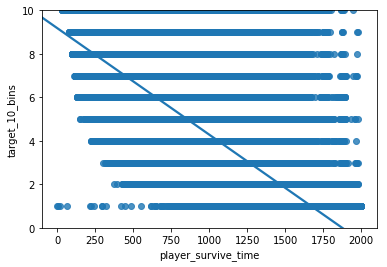

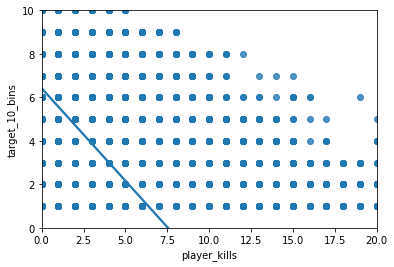

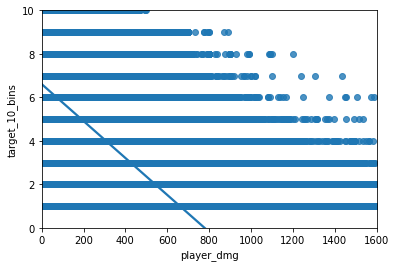

<Figure size 432x288 with 0 Axes>

In [27]:
#plt.scatter(X_test,y_test,color='red',markersize=0.2,alpha=0.4)
plt.figure()
_=sns.regplot(f.player_survive_time,f.target_10_bins,fit_reg=True)
plt.ylim(0,10)
plt.figure()
_=sns.regplot(f.player_kills,f.target_10_bins,fit_reg=True)
plt.ylim(0,10)
plt.xlim(0,20)
plt.figure()
_=sns.regplot(f.player_dmg,f.target_10_bins,fit_reg=True)
plt.ylim(0,10)
plt.xlim(0,1600)
plt.figure()


The plots do not show anything interesting since there is no way to tell how many data points lie on top of each other, but the lines show that as players place closer to one, the survival time, player kills, and damage dealt to other players generally increases.

(0, 10)

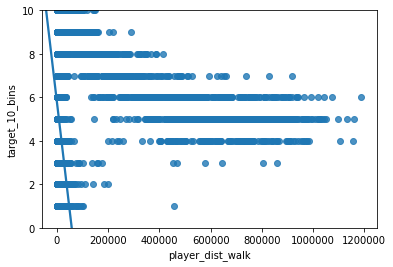

In [29]:
sns.regplot(f.player_dist_walk,f.target_10_bins,fit_reg=True)
plt.ylim(0,10)

## Tuning the model in XGBoost


Now that I tested and tuned the model in scikit learn and it was not very useful in improving accuracy in its predictions, I moved onto xgboost in hopes that it would provide better results.The dataset uploaded here is a cleaned up and conjoined version of the dataset uploaded in the beginning of this notebook. The data is then further prepared for tuning and model building in xgboost

In [8]:
flare = pd.read_csv('agg_stats.csv')
flare = flare[['player_survive_time','team_placement','player_kills','player_dmg','player_dist_ride',
               'player_dist_walk','player_dbno','player_assists']]
flare

,player_survive_time,team_placement,player_kills,player_dmg,player_dist_ride,player_dist_walk,player_dbno,player_assists
0,186.999,79,0,0,0.000000,170.954788,0,0
1,124.782,87,0,0,0.000000,66.545590,0,0
2,839.161,35,0,124,728.722656,610.168945,0,0
3,751.716,46,0,24,2646.184000,1431.292000,0,0
4,744.088,47,1,100,0.000000,723.102300,0,0
5,108.231,90,0,0,0.000000,0.000000,0,0
6,1006.527,29,4,438,1055.677610,1889.028000,0,0
7,741.473,48,0,0,0.000000,927.809937,0,0
8,290.769,67,0,0,0.000000,706.727400,0,0
9,337.259,63,0,0,0.000000,171.162720,0,0


In [9]:
# new xgboost dataset
mit = xgb.DMatrix(flare)
mit

In [11]:
# Check size of the xgboost dataframe and number of features
print("Dataset has {} entries and {} features".format(*flare.shape))

Dataset has 14011203 entries and 8 features


In [10]:
# Number and types of features
print(mit.feature_types)
print(mit.feature_names)

['float', 'int', 'int', 'int', 'float', 'float', 'int', 'int']
['player_survive_time', 'team_placement', 'player_kills', 'player_dmg', 'player_dist_ride', 'player_dist_walk', 'player_dbno', 'player_assists']


Setting up to train and  tune the model

In [12]:
y = flare.loc[:,'player_survive_time'].values

In [13]:
tire = flare.drop(columns='player_survive_time')
X = tire.loc[:,:].values

In [14]:
from sklearn.model_selection import train_test_split
Xtr,Xtst, ytr, ytst = train_test_split(X,y,test_size=0.3,random_state=21)

In [15]:
dtrain = xgb.DMatrix(Xtr,label=ytr)
dtest = xgb.DMatrix(Xtst,label=ytst)

In [16]:
from sklearn.metrics import mean_absolute_error
mean_train = np.mean(ytr)
baseline_predictions = np.ones(ytst.shape) * mean_train
mae_baseline = mean_absolute_error(ytst,baseline_predictions)
print("Baseline MAE is {:.2f}".format(mae_baseline))

Baseline MAE is 481.97


In [12]:
params = {
    'max_depth':8,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective':'reg:linear',
}
params['eval_metric'] = "mae"
num_boost_round = 500

In [13]:
#Inital training and tuning of the data
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[07:01:34] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[07:01:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned nodes, max_depth=8
[0]	Test-mae:504.476
Will train until Test-mae hasn't improved in 10 rounds.
[07:01:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 478 extra nodes, 0 pruned nodes, max_depth=8
[1]	Test-mae:354.817
[07:01:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 492 extra nodes, 0 pruned nodes, max_depth=8
[2]	Test-mae:252.3
[07:01:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=8
[3]	Test-mae:183.728
[07:02:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[4]	Test-mae:139.844
[07:02:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max

In [14]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=21,
    nfold=5,
    metrics={'mae'},
    early_stopping_rounds=10
)

cv_results

[07:04:33] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[07:04:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 466 extra nodes, 0 pruned nodes, max_depth=8
[07:04:39] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[07:04:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 466 extra nodes, 0 pruned nodes, max_depth=8
[07:04:44] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[07:04:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 466 extra nodes, 0 pruned nodes, max_depth=8
[07:04:50] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), 

[07:09:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 478 extra nodes, 0 pruned nodes, max_depth=8
[07:09:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[07:09:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 460 extra nodes, 0 pruned nodes, max_depth=8
[07:10:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=8
[07:10:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[07:10:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 478 extra nodes, 0 pruned nodes, max_depth=8
[07:10:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=8
[07:10:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 484 extra nodes, 0 pruned nodes, max_depth=8
[07:10:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned no

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
0,504.238623,0.086391,504.237958,0.341585
1,354.642486,0.061384,354.643488,0.228988
2,252.188031,0.042245,252.192801,0.159335
3,183.655179,0.032525,183.666879,0.101226
4,139.802716,0.026009,139.825467,0.089534
5,113.067194,0.019536,113.101370,0.069073
6,97.368853,0.025529,97.413443,0.057184
7,88.492886,0.022154,88.546809,0.047142
8,83.718387,0.025021,83.778767,0.041614
9,81.262540,0.012188,81.330022,0.030571


In [15]:
cv_results['test-mae-mean'].min()

79.0871458

In [16]:
#Tuning for best parameters for the model

gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(6,15)
    for min_child_weight in range(2,11)
]

min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))

    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight

    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )

    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)

print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=6, min_child_weight=2
[16:17:20] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[16:17:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[16:17:25] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[16:17:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[16:17:30] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[16:17:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[16:17:34] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exa

[16:21:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[16:21:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[16:21:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[16:21:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[16:21:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[16:22:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[16:22:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[16:22:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[16:22:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[16:26:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[16:26:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[16:26:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[16:26:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[16:26:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[16:26:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[16:26:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[16:26:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[16:26:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes

[16:30:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[16:30:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[16:30:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[16:30:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[16:30:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[16:31:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[16:31:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[16:31:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[16:31:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned no

[16:35:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[16:35:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[16:35:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[16:35:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[16:35:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[16:35:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[16:35:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[16:36:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[16:36:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nod

[16:40:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[16:40:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[16:40:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[16:40:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[16:40:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[16:40:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[16:40:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[16:40:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[16:40:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes

[16:45:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[16:45:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[16:45:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[16:45:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[16:45:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[16:45:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[16:45:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[16:45:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[16:45:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes

[16:49:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[16:49:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[16:49:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[16:49:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[16:50:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[16:50:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[16:50:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[16:50:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[16:50:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes

[16:54:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[16:54:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[16:54:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[16:54:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[16:54:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[16:54:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[16:54:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[16:54:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[16:54:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned node

[16:58:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[16:59:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[16:59:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[16:59:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[16:59:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[16:59:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[16:59:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[16:59:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[16:59:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes

[17:03:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[17:03:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:03:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[17:03:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[17:03:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[17:03:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:03:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[17:03:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:04:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes,

[17:08:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[17:08:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:08:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[17:08:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[17:08:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:08:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:08:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[17:08:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:08:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes

[17:12:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:12:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:12:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[17:12:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[17:12:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:12:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:12:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:13:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:13:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned node

[17:17:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:17:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[17:17:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[17:17:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:17:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[17:17:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:17:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[17:17:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:17:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, 

[17:21:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[17:21:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:21:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:21:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[17:21:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:21:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[17:21:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:21:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:22:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max

[17:26:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:26:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[17:26:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[17:26:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:26:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:26:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[17:26:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[17:26:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:26:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, m

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


	MAE 79.0722198 for 210 rounds
CV with max_depth=6, min_child_weight=3
[17:27:21] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[17:27:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[17:27:26] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[17:27:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[17:27:31] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[17:27:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[17:27:36] Tree method is automatically selected to be 'approx' for faster

[17:31:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[17:31:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[17:32:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[17:32:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[17:32:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[17:32:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[17:32:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[17:32:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[17:32:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[17:36:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[17:36:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:36:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[17:36:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[17:36:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:36:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:36:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:36:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[17:36:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes,

[17:41:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:41:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[17:41:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[17:41:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[17:41:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[17:41:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[17:41:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[17:41:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:41:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes,

[17:45:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:45:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:45:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[17:45:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[17:45:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:45:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:45:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:45:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[17:45:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes,

[17:49:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[17:49:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[17:49:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:49:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:49:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[17:49:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[17:49:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:49:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:49:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned node

[17:53:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[17:53:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:53:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[17:53:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:53:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:54:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[17:54:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[17:54:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[17:54:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned node

[17:57:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[17:57:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[17:58:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[17:58:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:58:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:58:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:58:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[17:58:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[17:58:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned node

[18:02:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[18:02:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:02:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:02:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:02:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[18:02:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:02:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:02:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:02:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned node

[18:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:06:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[18:06:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[18:06:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[18:06:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[18:06:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:06:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[18:06:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[18:06:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, 

[18:10:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:10:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:10:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[18:10:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:10:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:10:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:10:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[18:10:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:10:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned node

[18:14:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[18:14:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[18:14:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:14:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:14:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[18:14:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[18:14:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:14:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:14:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, 

[18:18:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[18:18:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[18:18:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[18:18:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:18:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[18:18:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[18:18:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:19:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[18:19:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, ma

[18:22:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:22:53] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[18:22:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:22:58] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[18:23:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:23:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:23:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:23:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 prun

[18:27:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:27:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:27:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:27:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:27:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:27:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:27:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:27:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:27:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[18:31:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:31:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:31:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:31:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:31:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:31:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[18:31:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[18:31:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[18:31:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nod

[18:35:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:35:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[18:35:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:35:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:35:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:35:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:35:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:35:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:35:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned no

[18:39:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[18:39:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:39:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:39:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[18:39:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:40:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:40:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:40:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:40:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned node

[18:43:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:43:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:44:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:44:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[18:44:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[18:44:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:44:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:44:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:44:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned node

[18:48:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[18:48:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:48:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[18:48:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:48:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:48:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:48:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:48:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[18:48:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned node

[18:52:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[18:52:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[18:52:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:52:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:52:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[18:52:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:52:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[18:52:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:52:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned node

[18:56:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[18:56:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[18:56:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[18:56:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[18:56:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:56:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[18:56:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[18:56:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[18:56:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, ma

[19:00:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:00:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:00:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:00:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[19:00:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:00:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:00:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[19:00:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:01:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes

[19:04:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:04:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[19:04:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:04:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[19:04:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:05:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:05:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[19:05:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[19:05:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes,

[19:08:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:08:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:09:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:09:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:09:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:09:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:09:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[19:09:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[19:09:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes

[19:13:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:13:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[19:13:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[19:13:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[19:13:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:13:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[19:13:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[19:13:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[19:13:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, ma

[19:17:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[19:17:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:17:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:17:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:17:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:17:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[19:17:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:17:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:17:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned node

[19:21:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[19:21:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[19:21:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:21:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:21:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:21:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:21:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:21:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:21:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes

[19:25:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:25:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:25:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:25:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:25:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:25:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:26:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:26:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:26:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[19:29:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[19:29:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:30:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:30:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:30:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:30:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:30:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:30:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[19:30:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned node

[19:34:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:34:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:34:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:34:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[19:34:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:34:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:34:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:34:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:34:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned node

[19:38:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:38:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[19:38:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:38:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:38:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:38:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:38:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:38:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:38:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nod

[19:42:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:42:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:42:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:42:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:42:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:42:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:42:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:42:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:43:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned no

[19:46:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[19:46:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:46:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[19:46:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:46:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:47:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:47:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:47:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:47:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes

[19:50:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:50:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[19:50:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[19:51:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:51:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:51:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[19:51:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[19:51:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[19:51:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, m

[19:55:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:55:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:55:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:55:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[19:55:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:55:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:55:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:55:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:55:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nod

[19:59:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:59:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:59:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:59:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:59:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:59:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[19:59:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:59:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:59:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nod

[20:03:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[20:03:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[20:03:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[20:03:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[20:03:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[20:03:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[20:03:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[20:04:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[20:04:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes

[20:07:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[20:08:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[20:08:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[20:08:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[20:08:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[20:08:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[20:08:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[20:08:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[20:08:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_

[20:12:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[20:12:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[20:12:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[20:12:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[20:12:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[20:12:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[20:12:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[20:12:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[20:12:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, ma

[20:16:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[20:16:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[20:16:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[20:16:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[20:16:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[20:17:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[20:17:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[20:17:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[20:17:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, m

[20:21:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[20:21:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[20:21:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[20:21:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[20:21:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[20:21:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[20:21:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[20:21:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[20:21:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, m

[20:25:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[20:25:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[20:25:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[20:25:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[20:25:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[20:25:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[20:25:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[20:25:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[20:26:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, 

[20:29:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[20:29:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[20:29:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[20:30:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[20:30:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[20:30:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[20:30:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[20:30:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[20:30:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, ma

[20:34:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[20:34:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[20:34:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[20:34:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[20:34:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[20:34:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[20:34:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[20:34:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[20:34:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[20:39:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[20:39:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[20:39:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[20:39:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[20:39:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[20:39:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[20:39:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[20:39:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[20:39:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned no

[20:43:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[20:43:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[20:43:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[20:43:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[20:43:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[20:43:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[20:43:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[20:43:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[20:43:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes,

[20:47:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[20:47:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[20:48:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[20:48:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[20:48:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[20:48:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[20:48:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[20:48:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[20:48:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes

[20:51:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[20:52:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[20:52:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[20:52:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[20:52:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[20:52:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[20:52:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[20:52:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[20:52:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, 

[20:56:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[20:56:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[20:56:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[20:56:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[20:56:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[20:56:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[20:56:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[20:56:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[20:56:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes,

[21:00:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[21:00:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[21:00:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:00:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[21:00:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[21:00:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[21:00:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[21:00:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[21:00:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes

[21:04:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[21:04:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[21:04:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[21:04:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[21:04:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[21:04:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[21:04:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[21:04:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[21:04:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, m

[21:08:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:08:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[21:08:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[21:08:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:08:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:08:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[21:08:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[21:08:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[21:08:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned node

[21:12:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[21:12:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[21:12:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[21:12:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[21:12:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[21:12:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[21:12:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[21:12:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[21:12:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, 

[21:16:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[21:16:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[21:16:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[21:16:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[21:16:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:16:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[21:16:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[21:16:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[21:16:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes,

[21:20:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[21:20:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[21:20:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[21:20:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:20:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[21:20:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[21:20:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[21:20:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[21:20:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, ma

[21:24:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[21:24:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[21:24:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[21:24:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[21:24:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:24:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[21:24:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[21:24:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[21:24:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes,

[21:28:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[21:28:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[21:28:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[21:28:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[21:28:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[21:28:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[21:28:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[21:28:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[21:28:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, ma

[21:32:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[21:32:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[21:32:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[21:32:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[21:32:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:32:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[21:32:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[21:32:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[21:32:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, 

[21:36:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[21:36:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[21:36:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[21:36:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[21:36:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[21:36:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[21:36:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[21:36:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[21:36:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[21:40:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:40:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:40:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[21:40:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[21:40:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[21:40:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[21:40:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[21:41:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[21:41:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[21:44:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[21:44:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[21:44:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:44:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[21:44:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[21:45:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[21:45:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[21:45:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[21:45:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes

[21:48:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[21:48:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[21:48:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[21:49:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[21:49:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[21:49:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:49:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[21:49:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[21:49:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nod

[21:52:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[21:52:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:53:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:53:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[21:53:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[21:53:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[21:53:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:53:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[21:53:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned no

[21:57:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[21:57:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:57:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[21:57:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[21:57:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[21:57:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[21:57:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[21:57:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[21:57:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nod

[22:01:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[22:01:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[22:01:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[22:01:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[22:01:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[22:01:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[22:01:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[22:01:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[22:01:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned node

[22:05:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[22:05:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[22:05:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[22:05:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[22:05:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[22:05:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[22:05:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[22:05:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[22:05:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, 

[22:09:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[22:09:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[22:09:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[22:09:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[22:09:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[22:09:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[22:09:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[22:09:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[22:09:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, m

[22:13:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[22:13:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[22:13:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[22:13:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[22:13:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[22:13:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[22:13:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[22:13:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[22:13:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, m

[22:17:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[22:17:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[22:17:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[22:17:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[22:17:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[22:17:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[22:17:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[22:17:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[22:17:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes

[22:21:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[22:21:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[22:21:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[22:21:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[22:21:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[22:21:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[22:21:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[22:21:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[22:21:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, 

[22:25:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[22:25:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[22:25:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[22:25:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[22:25:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[22:25:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[22:25:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[22:25:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[22:25:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, 

[22:29:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[22:29:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[22:29:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[22:29:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[22:29:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[22:29:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[22:29:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[22:29:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[22:29:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, ma

[22:33:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[22:33:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[22:33:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[22:33:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[22:33:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[22:33:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[22:33:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[22:33:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[22:33:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, m

[22:37:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[22:37:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[22:37:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[22:37:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[22:37:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[22:37:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[22:37:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[22:37:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[22:37:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes

[22:41:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[22:41:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[22:41:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[22:41:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[22:41:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[22:41:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[22:41:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[22:41:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[22:41:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, 

[22:45:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[22:45:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[22:45:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[22:45:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[22:45:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[22:45:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[22:45:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[22:45:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[22:46:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, m

[22:49:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[22:49:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[22:49:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[22:49:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[22:49:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[22:49:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[22:49:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[22:49:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[22:50:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, m

[22:53:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[22:53:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[22:53:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[22:53:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[22:53:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[22:53:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[22:54:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[22:54:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[22:54:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max

[22:57:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[22:57:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[22:57:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[22:57:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[22:57:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[22:58:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[22:58:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
	MAE 79.06922759999999 for 284 rounds
CV with max_depth=6, min_child_weight=8
[22:58:22] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single ma

[23:01:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[23:01:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[23:02:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[23:02:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[23:02:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[23:02:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[23:02:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[23:02:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[23:02:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[23:06:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[23:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[23:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[23:06:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[23:06:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[23:06:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[23:06:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[23:06:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[23:06:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned node

[23:10:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[23:10:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[23:10:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[23:10:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[23:10:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[23:10:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[23:10:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[23:10:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[23:10:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes

[23:14:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[23:14:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[23:14:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[23:14:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[23:14:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[23:14:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[23:14:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[23:14:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[23:14:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes,

[23:18:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[23:18:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[23:18:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[23:18:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[23:18:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[23:18:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[23:18:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[23:18:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[23:18:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned node

[23:22:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[23:22:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[23:22:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[23:22:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[23:22:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[23:22:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[23:22:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[23:22:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[23:23:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned node

[23:26:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[23:26:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[23:26:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[23:26:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[23:26:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[23:26:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[23:27:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[23:27:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[23:27:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes,

[23:30:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[23:30:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[23:30:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[23:30:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[23:31:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[23:31:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[23:31:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[23:31:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[23:31:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes,

[23:34:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[23:34:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[23:34:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[23:35:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[23:35:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[23:35:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[23:35:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[23:35:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[23:35:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes,

[23:38:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[23:39:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[23:39:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[23:39:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[23:39:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[23:39:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[23:39:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[23:39:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[23:39:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, ma

[23:43:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[23:43:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[23:43:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[23:43:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[23:43:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[23:43:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[23:43:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[23:43:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[23:43:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, 

[23:47:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[23:47:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[23:47:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[23:47:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[23:47:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[23:47:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[23:47:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[23:47:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[23:47:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, m

[23:51:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[23:51:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[23:51:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[23:51:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[23:51:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[23:51:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[23:51:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[23:51:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[23:51:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes,

[23:55:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[23:55:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[23:55:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[23:55:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[23:55:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[23:55:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[23:55:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[23:55:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[23:55:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_

[23:59:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[23:59:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[23:59:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[23:59:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[23:59:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[23:59:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[23:59:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[23:59:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[23:59:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, 

[00:03:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[00:03:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[00:03:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[00:03:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[00:03:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[00:03:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[00:03:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[00:03:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[00:03:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[00:07:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[00:07:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[00:07:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[00:07:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[00:07:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[00:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[00:07:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[00:07:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[00:08:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned no

[00:11:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[00:11:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[00:11:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[00:11:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[00:11:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[00:11:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[00:12:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[00:12:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[00:12:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes

[00:15:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[00:15:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[00:15:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[00:15:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[00:16:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[00:16:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[00:16:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[00:16:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[00:16:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, m

[00:19:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[00:19:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[00:20:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[00:20:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[00:20:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[00:20:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[00:20:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[00:20:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[00:20:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, 

[00:24:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[00:24:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[00:24:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[00:24:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[00:24:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[00:24:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[00:24:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[00:24:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[00:24:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes

[00:28:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[00:28:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[00:28:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[00:28:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[00:28:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[00:28:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[00:28:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[00:28:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[00:28:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, m

[00:32:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[00:32:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[00:32:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[00:32:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[00:32:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[00:32:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[00:32:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[00:32:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[00:32:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes

[00:36:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[00:36:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[00:36:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[00:36:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[00:36:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[00:36:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[00:36:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[00:36:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[00:36:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, 

[00:40:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[00:40:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[00:40:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[00:40:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[00:40:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[00:40:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[00:40:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[00:40:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[00:40:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, 

[00:44:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[00:44:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[00:44:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[00:44:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[00:44:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[00:44:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[00:44:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[00:44:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[00:44:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes,

[00:48:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[00:48:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[00:48:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[00:48:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[00:48:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[00:48:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[00:48:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[00:48:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[00:48:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, 

[00:52:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[00:52:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[00:52:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[00:52:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[00:52:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[00:52:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[00:52:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[00:52:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[00:52:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[00:56:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[00:56:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[00:56:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[00:56:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[00:56:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[00:57:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[00:57:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[00:57:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[00:57:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned no

[01:00:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[01:00:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[01:00:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[01:01:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[01:01:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[01:01:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[01:01:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[01:01:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[01:01:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned node

[01:04:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[01:05:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[01:05:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[01:05:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[01:05:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[01:05:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[01:05:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[01:05:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[01:05:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned node

[01:09:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[01:09:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[01:09:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[01:09:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[01:09:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[01:09:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[01:09:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[01:09:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[01:09:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, 

[01:13:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[01:13:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[01:13:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[01:13:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[01:13:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[01:13:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[01:13:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[01:13:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[01:13:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned node

[01:17:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[01:17:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[01:17:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[01:17:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[01:17:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[01:17:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[01:17:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[01:17:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[01:17:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned node

[01:21:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[01:21:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[01:21:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[01:21:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[01:21:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[01:21:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[01:21:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[01:21:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[01:21:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, m

[01:25:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[01:25:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[01:25:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[01:25:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[01:25:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[01:25:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[01:25:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[01:25:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[01:25:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes,

[01:29:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[01:29:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[01:29:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[01:29:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[01:29:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[01:29:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[01:29:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[01:29:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[01:30:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, ma

[01:33:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[01:33:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[01:33:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[01:33:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[01:33:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[01:33:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[01:34:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[01:34:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[01:34:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, ma

[01:37:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[01:37:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[01:37:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[01:37:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[01:37:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[01:38:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[01:38:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[01:38:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[01:38:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, m

[01:41:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[01:41:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[01:41:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[01:41:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[01:42:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[01:42:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[01:42:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[01:42:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[01:42:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, m

[01:45:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[01:45:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[01:45:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[01:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[01:46:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[01:46:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[01:46:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[01:46:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[01:46:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, m

[01:49:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[01:49:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[01:50:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[01:50:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[01:50:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[01:50:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[01:50:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[01:50:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[01:50:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, ma

[01:54:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=7
[01:54:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=7
[01:54:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=7
[01:54:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=7
[01:54:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=7
[01:54:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=7
[01:54:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=7
[01:54:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=7
[01:55:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned no

[01:59:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=7
[01:59:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=7
[01:59:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=7
[01:59:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=7
[01:59:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=7
[01:59:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=7
[01:59:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=7
[01:59:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=7
[02:00:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned no

[02:04:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=7
[02:04:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=7
[02:04:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=7
[02:04:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=7
[02:04:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=7
[02:04:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=7
[02:04:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=7
[02:04:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=7
[02:04:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned no

[02:09:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=7
[02:09:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=7
[02:09:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=7
[02:09:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=7
[02:09:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=7
[02:09:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=7
[02:09:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=7
[02:09:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=7
[02:09:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned no

[02:14:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=7
[02:14:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=7
[02:14:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=7
[02:14:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=7
[02:14:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=7
[02:14:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=7
[02:14:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=7
[02:14:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=7
[02:14:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nod

[02:18:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=7
[02:18:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=7
[02:18:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=7
[02:19:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=7
[02:19:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=7
[02:19:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=7
[02:19:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=7
[02:19:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=7
[02:19:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned no

[02:23:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=7
[02:23:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=7
[02:23:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=7
[02:23:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=7
[02:23:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=7
[02:24:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=7
[02:24:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=7
[02:24:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=7
[02:24:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nod

[02:28:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=7
[02:28:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=7
[02:28:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=7
[02:28:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=7
[02:28:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=7
[02:28:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=7
[02:28:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=7
[02:29:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=7
[02:29:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned node

[02:33:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=7
[02:33:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=7
[02:33:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=7
[02:33:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=7
[02:33:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=7
[02:33:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=7
[02:33:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=7
[02:33:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=7
[02:33:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned no

[02:38:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=7
[02:38:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=7
[02:38:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=7
[02:38:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=7
[02:38:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=7
[02:38:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=7
[02:38:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=7
[02:38:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=7
[02:38:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nod

[02:43:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=7
[02:43:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=7
[02:43:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=7
[02:43:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=7
[02:43:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=7
[02:43:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=7
[02:43:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=7
[02:43:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=7
[02:43:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned no

[02:48:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=7
[02:48:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=7
[02:48:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=7
[02:48:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=7
[02:48:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=7
[02:48:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=7
[02:48:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=7
[02:48:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=7
[02:48:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned no

[02:52:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=7
[02:53:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=7
[02:53:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=7
[02:53:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=7
[02:53:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=7
[02:53:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=7
[02:53:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=7
[02:53:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=7
[02:53:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned no

[02:57:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=7
[02:57:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=7
[02:57:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=7
[02:57:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=7
[02:58:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=7
[02:58:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=7
[02:58:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=7
[02:58:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=7
[02:58:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned no

[03:02:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=7
[03:02:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=7
[03:02:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=7
[03:02:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=7
[03:02:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=7
[03:02:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=7
[03:02:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=7
[03:03:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=7
[03:03:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned no

[03:07:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=7
[03:07:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=7
[03:07:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=7
[03:07:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=7
[03:07:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=7
[03:07:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=7
[03:07:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=7
[03:07:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=7
[03:07:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned node

[03:12:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=7
[03:12:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=7
[03:12:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=7
[03:12:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=7
[03:12:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=7
[03:12:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=7
[03:12:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=7
[03:12:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=7
[03:12:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned node

[03:16:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=7
[03:16:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=7
[03:17:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=7
[03:17:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=7
[03:17:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=7
[03:17:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=7
[03:17:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=7
[03:17:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=7
[03:17:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned no

[03:21:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=7
[03:21:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=7
[03:21:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=7
[03:21:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=7
[03:21:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=7
[03:21:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=7
[03:22:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=7
[03:22:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=7
[03:22:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned no

[03:26:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=7
[03:26:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=7
[03:26:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=7
[03:26:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=7
[03:26:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=7
[03:26:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=7
[03:27:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=7
[03:27:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=7
[03:27:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned no

[03:31:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=7
[03:31:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=7
[03:31:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=7
[03:31:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=7
[03:31:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=7
[03:31:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=7
[03:31:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=7
[03:31:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=7
[03:32:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nod

[03:36:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=7
[03:36:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=7
[03:36:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=7
[03:36:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=7
[03:36:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=7
[03:36:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=7
[03:36:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=7
[03:36:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=7
[03:36:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned no

[03:41:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=7
[03:41:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=7
[03:41:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=7
[03:41:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=7
[03:41:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[03:41:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=7
[03:41:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=7
[03:41:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=7
[03:41:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nod

[03:45:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=7
[03:46:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[03:46:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=7
[03:46:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=7
[03:46:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=7
[03:46:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=7
[03:46:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=7
[03:46:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=7
[03:46:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned node

[03:50:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=7
[03:50:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=7
[03:50:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=7
[03:51:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=7
[03:51:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=7
[03:51:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=7
[03:51:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=7
[03:51:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=7
[03:51:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nod

[03:55:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=7
[03:55:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=7
[03:55:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=7
[03:55:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=7
[03:55:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=7
[03:55:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=7
[03:56:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=7
[03:56:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=7
[03:56:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nod

[04:00:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=7
[04:00:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=7
[04:00:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=7
[04:00:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=7
[04:00:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=7
[04:00:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=7
[04:00:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[04:00:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=7
[04:00:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned node

[04:05:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=7
[04:05:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=7
[04:05:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=7
[04:05:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=7
[04:05:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=7
[04:05:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=7
[04:05:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=7
[04:05:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=7
[04:05:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nod

[04:10:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=7
[04:10:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=7
[04:10:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=7
[04:10:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=7
[04:10:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=7
[04:10:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=7
[04:10:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=7
[04:10:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=7
[04:10:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned no

[04:14:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=7
[04:15:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=7
[04:15:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=7
[04:15:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=7
[04:15:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=7
[04:15:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=7
[04:15:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=7
[04:15:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=7
[04:15:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned no

[04:19:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=7
[04:19:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=7
[04:19:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=7
[04:19:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[04:20:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=7
[04:20:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=7
[04:20:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=7
[04:20:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=7
[04:20:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nod

[04:24:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=7
[04:24:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=7
[04:24:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=7
[04:24:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=7
[04:24:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=7
[04:24:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=7
[04:24:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=7
[04:25:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=7
[04:25:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned node

[04:29:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=7
[04:29:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=7
[04:29:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=7
[04:29:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=7
[04:29:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=7
[04:29:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=7
[04:29:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=7
[04:29:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=7
[04:29:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nod

[04:34:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=7
[04:34:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=7
[04:34:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=7
[04:34:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=7
[04:34:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=7
[04:34:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=7
[04:34:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=7
[04:34:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=7
[04:34:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned no

[04:38:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=7
[04:38:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=7
[04:39:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=7
[04:39:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=7
[04:39:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=7
[04:39:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[04:39:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=7
[04:39:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=7
[04:39:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes

[04:43:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=7
[04:43:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=7
[04:43:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=7
[04:43:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=7
[04:43:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=7
[04:43:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=7
[04:44:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=7
[04:44:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=7
[04:44:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nod

[04:48:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=7
[04:48:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=7
[04:48:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=7
[04:48:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=7
[04:48:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=7
[04:48:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=7
[04:48:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=7
[04:48:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=7
[04:48:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nod

[04:53:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=7
[04:53:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=7
[04:53:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=7
[04:53:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=7
[04:53:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=7
[04:53:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=7
[04:53:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=7
[04:53:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=7
[04:53:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nod

[04:57:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=7
[04:57:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=7
[04:58:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=7
[04:58:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=7
[04:58:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=7
[04:58:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=7
[04:58:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=7
[04:58:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=7
[04:58:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned no

[05:02:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=7
[05:02:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=7
[05:03:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=7
[05:03:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=7
[05:03:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=7
[05:03:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=7
[05:03:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=7
[05:03:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=7
[05:03:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned no

[05:07:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=7
[05:07:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[05:07:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=7
[05:07:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=7
[05:08:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=7
[05:08:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=7
[05:08:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=7
[05:08:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[05:08:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nod

[05:12:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=7
[05:12:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=7
[05:12:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=7
[05:12:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=7
[05:12:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=7
[05:12:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=7
[05:13:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=7
[05:13:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=7
[05:13:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nod

[05:17:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=7
[05:17:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=7
[05:17:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[05:17:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=7
[05:17:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=7
[05:17:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[05:17:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=7
[05:17:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=7
[05:17:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned node

[05:22:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=7
[05:22:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=7
[05:22:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=7
[05:22:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=7
[05:22:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=7
[05:22:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=7
[05:22:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=7
[05:22:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=7
[05:22:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nod

[05:27:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[05:27:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=7
[05:27:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=7
[05:27:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=7
[05:27:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=7
[05:27:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[05:27:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=7
[05:27:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=7
[05:27:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes

[05:31:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=7
[05:31:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=7
[05:32:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=7
[05:32:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=7
[05:32:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=7
[05:32:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=7
[05:32:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=7
[05:32:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=7
[05:32:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned node

[05:36:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=7
[05:36:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=7
[05:36:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=7
[05:36:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=7
[05:36:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=7
[05:37:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=7
[05:37:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=7
[05:37:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=7
[05:37:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nod

[05:41:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=7
[05:41:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=7
[05:41:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[05:41:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=7
[05:41:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=7
[05:41:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=7
[05:41:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[05:41:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=7
[05:42:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned node

[05:46:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=7
[05:46:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[05:46:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=7
[05:46:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=7
[05:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=7
[05:46:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=7
[05:46:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=7
[05:46:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=7
[05:46:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned node

[05:50:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=7
[05:51:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=7
[05:51:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=7
[05:51:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=7
[05:51:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=7
[05:51:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=7
[05:51:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=7
[05:51:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=7
[05:51:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned no

[05:55:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=7
[05:55:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=7
[05:56:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=7
[05:56:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=7
[05:56:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=7
[05:56:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=7
[05:56:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=7
[05:56:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=7
[05:56:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned no

[06:00:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=7
[06:00:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=7
[06:00:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[06:00:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=7
[06:01:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=7
[06:01:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=7
[06:01:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=7
[06:01:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=7
[06:01:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nod

[06:05:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=7
[06:05:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=7
[06:05:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=7
[06:05:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=7
[06:05:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[06:05:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=7
[06:05:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=7
[06:06:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=7
[06:06:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes

[06:10:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=7
[06:10:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=7
[06:10:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=7
[06:10:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=7
[06:10:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=7
[06:10:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=7
[06:10:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=7
[06:10:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=7
[06:10:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned no

[06:15:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[06:15:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=7
[06:15:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=7
[06:15:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[06:15:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=7
[06:15:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=7
[06:15:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[06:15:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=7
[06:15:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes,

[06:19:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=7
[06:19:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=7
[06:20:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=7
[06:20:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=7
[06:20:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=7
[06:20:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=7
[06:20:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=7
[06:20:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=7
[06:20:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nod

[06:24:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=7
[06:24:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=7
[06:24:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=7
[06:24:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=7
[06:24:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=7
[06:25:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=7
[06:25:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=7
[06:25:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=7
[06:25:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nod

[06:29:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=7
[06:29:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=7
[06:29:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=7
[06:29:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=7
[06:29:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=7
[06:29:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=7
[06:29:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=7
[06:29:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=7
[06:29:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned no

[06:34:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=7
[06:34:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=7
[06:34:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=7
[06:34:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=7
[06:34:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[06:34:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=7
[06:34:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=7
[06:34:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=7
[06:34:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned node

[06:38:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=7
[06:39:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=7
[06:39:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=7
[06:39:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=7
[06:39:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=7
[06:39:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=7
[06:39:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=7
[06:39:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=7
[06:39:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned no

[06:43:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=7
[06:43:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=7
[06:44:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=7
[06:44:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=7
[06:44:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=7
[06:44:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=7
[06:44:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=7
[06:44:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=7
[06:44:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned no

[06:48:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[06:48:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=7
[06:48:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=7
[06:48:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=7
[06:48:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=7
[06:49:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=7
[06:49:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=7
[06:49:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=7
[06:49:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned node

[06:53:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=7
[06:53:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=7
[06:53:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=7
[06:53:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=7
[06:53:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=7
[06:53:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[06:53:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=7
[06:53:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=7
[06:54:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nod

[06:58:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=7
[06:58:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=7
[06:58:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=7
[06:58:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[06:58:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=7
[06:58:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=7
[06:58:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=7
[06:58:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=7
[06:58:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nod

[07:03:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=7
[07:03:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=7
[07:03:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=7
[07:03:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=7
[07:03:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=7
[07:03:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[07:03:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=7
[07:03:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=7
[07:03:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nod

[07:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=7
[07:07:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=7
[07:07:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=7
[07:08:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=7
[07:08:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=7
[07:08:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=7
[07:08:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=7
[07:08:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=7
[07:08:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned node

[07:12:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=7
[07:12:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=7
[07:12:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[07:12:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=7
[07:12:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=7
[07:12:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[07:13:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=7
[07:13:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=7
[07:13:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, 

[07:17:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=7
[07:17:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=7
[07:17:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=7
[07:17:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=7
[07:17:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=7
[07:17:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=7
[07:17:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=7
[07:17:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=7
[07:17:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nod

[07:22:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=7
[07:22:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=7
[07:22:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=7
[07:22:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=7
[07:22:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=7
[07:22:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[07:22:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=7
[07:22:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=7
[07:22:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nod

[07:26:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=7
[07:26:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=7
[07:26:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=7
[07:27:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=7
[07:27:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=7
[07:27:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=7
[07:27:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=7
[07:27:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=7
[07:27:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned no

[07:31:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=7
[07:31:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=7
[07:31:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=7
[07:31:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=7
[07:32:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=7
[07:32:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=7
[07:32:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=7
[07:32:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=7
[07:32:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned no

[07:36:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=7
[07:36:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=7
[07:36:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=7
[07:36:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=7
[07:36:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=7
[07:36:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=7
[07:36:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=7
[07:37:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=7
[07:37:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned no

[07:41:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=7
[07:41:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[07:41:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=7
[07:41:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=7
[07:41:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=7
[07:41:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=7
[07:41:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=7
[07:41:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=7
[07:41:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nod

[07:46:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=7
[07:46:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=7
[07:46:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=7
[07:46:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=7
[07:46:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=7
[07:46:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[07:46:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=7
[07:46:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[07:46:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes

[07:50:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=7
[07:50:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=7
[07:50:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[07:51:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=7
[07:51:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=7
[07:51:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=7
[07:51:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[07:51:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[07:51:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes

[07:55:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=7
[07:55:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=7
[07:55:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=7
[07:55:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=7
[07:55:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[07:55:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=7
[07:55:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=7
[07:56:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=7
[07:56:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned node

[08:00:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=7
[08:00:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=7
[08:00:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=7
[08:00:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=7
[08:00:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=7
[08:00:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[08:00:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=7
[08:00:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=7
[08:00:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned node

[08:04:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=7
[08:05:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=7
[08:05:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=7
[08:05:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[08:05:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[08:05:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=7
[08:05:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=7
[08:05:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=7
[08:05:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes

[08:09:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=7
[08:09:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=7
[08:09:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=7
[08:09:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=7
[08:09:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=7
[08:09:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=7
[08:10:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=7
[08:10:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=7
[08:10:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned no

[08:14:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=7
[08:14:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=7
[08:14:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=7
[08:14:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=7
[08:14:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=7
[08:14:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=7
[08:15:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=7
[08:15:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=7
[08:15:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned no

[08:19:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=7
[08:19:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=7
[08:19:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=7
[08:19:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=7
[08:19:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=7
[08:19:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=7
[08:19:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=7
[08:19:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=7
[08:20:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned no

[08:24:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=7
[08:24:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=7
[08:24:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=7
[08:24:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[08:24:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=7
[08:24:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=7
[08:24:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[08:24:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=7
[08:24:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nod

[08:29:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=7
[08:29:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[08:29:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=7
[08:29:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=7
[08:29:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=7
[08:29:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=7
[08:29:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=7
[08:29:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=7
[08:29:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned node

[08:33:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=7
[08:34:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=7
[08:34:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=7
[08:34:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=7
[08:34:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=7
[08:34:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=7
[08:34:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=7
[08:34:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[08:34:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nod

[08:38:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=7
[08:38:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=7
[08:38:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=7
[08:38:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=7
[08:38:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=7
[08:39:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=7
[08:39:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=7
[08:39:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=7
[08:39:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned no

[08:43:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[08:43:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[08:43:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=7
[08:43:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=7
[08:43:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[08:43:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=7
[08:43:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[08:43:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=7
[08:43:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, m

[08:48:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[08:48:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=7
[08:48:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=7
[08:48:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=7
[08:48:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=7
[08:48:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=7
[08:48:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=7
[08:48:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=7
[08:48:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned node

[08:53:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=7
[08:53:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=7
[08:53:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=7
[08:53:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[08:53:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=7
[08:53:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=7
[08:53:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[08:53:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=7
[08:53:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nod

[08:57:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[08:57:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=7
[08:57:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=7
[08:57:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=7
[08:58:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=7
[08:58:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[08:58:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=7
[08:58:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=7
[08:58:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, m

[09:02:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[09:02:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=7
[09:02:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[09:02:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=7
[09:02:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=7
[09:02:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=7
[09:02:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=7
[09:03:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=7
[09:03:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes,

[09:07:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=7
[09:07:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[09:07:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[09:07:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=7
[09:07:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=7
[09:07:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=7
[09:07:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=7
[09:07:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[09:07:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes

[09:12:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 486 extra nodes, 0 pruned nodes, max_depth=8
[09:12:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 486 extra nodes, 0 pruned nodes, max_depth=8
[09:12:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 490 extra nodes, 0 pruned nodes, max_depth=8
[09:12:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=8
[09:12:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 494 extra nodes, 0 pruned nodes, max_depth=8
[09:12:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=8
[09:12:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=8
[09:12:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 496 extra nodes, 0 pruned nodes, max_depth=8
[09:12:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned no

[09:17:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 480 extra nodes, 0 pruned nodes, max_depth=8
[09:17:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 478 extra nodes, 0 pruned nodes, max_depth=8
[09:18:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 454 extra nodes, 0 pruned nodes, max_depth=8
[09:18:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 470 extra nodes, 0 pruned nodes, max_depth=8
[09:18:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 492 extra nodes, 0 pruned nodes, max_depth=8
[09:18:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 452 extra nodes, 0 pruned nodes, max_depth=8
[09:18:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 pruned nodes, max_depth=8
[09:18:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 450 extra nodes, 0 pruned nodes, max_depth=8
[09:18:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 460 extra nodes, 0 pruned no

[09:23:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[09:23:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[09:23:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=8
[09:23:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[09:23:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=8
[09:23:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[09:23:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[09:23:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=8
[09:23:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned no

[09:29:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 pruned nodes, max_depth=8
[09:29:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 452 extra nodes, 0 pruned nodes, max_depth=8
[09:29:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=8
[09:29:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 422 extra nodes, 0 pruned nodes, max_depth=8
[09:29:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned nodes, max_depth=8
[09:29:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 482 extra nodes, 0 pruned nodes, max_depth=8
[09:29:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 422 extra nodes, 0 pruned nodes, max_depth=8
[09:29:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=8
[09:29:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 456 extra nodes, 0 pruned no

[09:34:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=8
[09:34:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=8
[09:34:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[09:34:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[09:34:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[09:34:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[09:34:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[09:35:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=8
[09:35:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned no

[09:40:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned nodes, max_depth=8
[09:40:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 462 extra nodes, 0 pruned nodes, max_depth=8
[09:40:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 460 extra nodes, 0 pruned nodes, max_depth=8
[09:40:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 450 extra nodes, 0 pruned nodes, max_depth=8
[09:40:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=8
[09:40:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=8
[09:40:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=8
[09:40:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 402 extra nodes, 0 pruned nodes, max_depth=8
[09:40:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 450 extra nodes, 0 pruned no

[09:45:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[09:45:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=8
[09:45:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=8
[09:45:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=8
[09:45:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[09:45:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[09:46:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=8
[09:46:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 496 extra nodes, 0 pruned nodes, max_depth=8
[09:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned no

[09:51:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=8
[09:51:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=8
[09:51:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=8
[09:51:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned nodes, max_depth=8
[09:51:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=8
[09:51:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 434 extra nodes, 0 pruned nodes, max_depth=8
[09:51:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=8
[09:51:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 pruned nodes, max_depth=8
[09:51:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 0 pruned no

[09:56:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=8
[09:56:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=8
[09:56:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=8
[09:56:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=8
[09:56:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 496 extra nodes, 0 pruned nodes, max_depth=8
[09:57:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 494 extra nodes, 0 pruned nodes, max_depth=8
[09:57:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 496 extra nodes, 0 pruned nodes, max_depth=8
[09:57:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 490 extra nodes, 0 pruned nodes, max_depth=8
[09:57:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned no

[10:02:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=8
[10:02:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=8
[10:02:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=8
[10:02:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 438 extra nodes, 0 pruned nodes, max_depth=8
[10:02:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=8
[10:02:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=8
[10:02:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=8
[10:02:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=8
[10:02:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned no

[10:07:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=8
[10:07:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 494 extra nodes, 0 pruned nodes, max_depth=8
[10:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 486 extra nodes, 0 pruned nodes, max_depth=8
[10:07:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 496 extra nodes, 0 pruned nodes, max_depth=8
[10:08:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 490 extra nodes, 0 pruned nodes, max_depth=8
[10:08:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=8
[10:08:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=8
[10:08:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=8
[10:08:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 486 extra nodes, 0 pruned no

[10:13:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=8
[10:13:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=8
[10:13:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 474 extra nodes, 0 pruned nodes, max_depth=8
[10:13:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 0 pruned nodes, max_depth=8
[10:13:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 0 pruned nodes, max_depth=8
[10:13:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 0 pruned nodes, max_depth=8
[10:13:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=8
[10:13:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 0 pruned nodes, max_depth=8
[10:14:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 442 extra nodes, 0 pruned no

[10:18:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 486 extra nodes, 0 pruned nodes, max_depth=8
[10:19:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned nodes, max_depth=8
[10:19:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 492 extra nodes, 0 pruned nodes, max_depth=8
[10:19:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 484 extra nodes, 0 pruned nodes, max_depth=8
[10:19:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 478 extra nodes, 0 pruned nodes, max_depth=8
[10:19:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 488 extra nodes, 0 pruned nodes, max_depth=8
[10:19:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned nodes, max_depth=8
[10:19:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 494 extra nodes, 0 pruned nodes, max_depth=8
[10:19:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 470 extra nodes, 0 pruned no

[10:24:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=8
[10:24:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 0 pruned nodes, max_depth=8
[10:24:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=8
[10:24:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=8
[10:24:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=8
[10:25:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=8
[10:25:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=8
[10:25:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=8
[10:25:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned no

[10:30:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 488 extra nodes, 0 pruned nodes, max_depth=8
[10:30:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 476 extra nodes, 0 pruned nodes, max_depth=8
[10:30:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 484 extra nodes, 0 pruned nodes, max_depth=8
[10:30:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 454 extra nodes, 0 pruned nodes, max_depth=8
[10:30:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 490 extra nodes, 0 pruned nodes, max_depth=8
[10:30:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 478 extra nodes, 0 pruned nodes, max_depth=8
[10:30:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 482 extra nodes, 0 pruned nodes, max_depth=8
[10:30:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 480 extra nodes, 0 pruned nodes, max_depth=8
[10:30:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned no

[10:35:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=8
[10:35:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=8
[10:36:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=8
[10:36:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=8
[10:36:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=8
[10:36:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=8
[10:36:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=8
[10:36:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=8
[10:36:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 pruned nod

[10:41:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned nodes, max_depth=8
[10:41:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 490 extra nodes, 0 pruned nodes, max_depth=8
[10:41:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 462 extra nodes, 0 pruned nodes, max_depth=8
[10:41:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 462 extra nodes, 0 pruned nodes, max_depth=8
[10:41:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 448 extra nodes, 0 pruned nodes, max_depth=8
[10:41:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 486 extra nodes, 0 pruned nodes, max_depth=8
[10:41:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 462 extra nodes, 0 pruned nodes, max_depth=8
[10:41:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 450 extra nodes, 0 pruned nodes, max_depth=8
[10:41:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned no

[10:47:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 0 pruned nodes, max_depth=8
[10:47:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 0 pruned nodes, max_depth=8
[10:47:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=8
[10:47:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=8
[10:47:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=8
[10:47:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=8
	MAE 79.0956802 for 16 rounds
CV with max_depth=9, min_child_weight=2
[10:47:41] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[10:47:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 828 extra no

[10:53:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 938 extra nodes, 0 pruned nodes, max_depth=9
[10:53:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 928 extra nodes, 0 pruned nodes, max_depth=9
[10:53:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 932 extra nodes, 0 pruned nodes, max_depth=9
[10:53:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 866 extra nodes, 0 pruned nodes, max_depth=9
[10:53:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 934 extra nodes, 0 pruned nodes, max_depth=9
[10:53:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 940 extra nodes, 0 pruned nodes, max_depth=9
[10:53:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 912 extra nodes, 0 pruned nodes, max_depth=9
[10:53:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 930 extra nodes, 0 pruned nodes, max_depth=9
[10:53:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 974 extra nodes, 0 pruned no

[10:59:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 826 extra nodes, 0 pruned nodes, max_depth=9
[10:59:35] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[10:59:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 824 extra nodes, 0 pruned nodes, max_depth=9
[10:59:41] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[10:59:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 828 extra nodes, 0 pruned nodes, max_depth=9
[10:59:48] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[10:59:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 822 extra nodes, 0 pruned nodes, max_depth=9
[10:59:54] Tree method is automa

[11:05:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 908 extra nodes, 0 pruned nodes, max_depth=9
[11:05:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 912 extra nodes, 0 pruned nodes, max_depth=9
[11:05:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 942 extra nodes, 0 pruned nodes, max_depth=9
[11:05:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 828 extra nodes, 0 pruned nodes, max_depth=9
[11:05:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 896 extra nodes, 0 pruned nodes, max_depth=9
[11:06:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 932 extra nodes, 0 pruned nodes, max_depth=9
[11:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 812 extra nodes, 0 pruned nodes, max_depth=9
[11:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 824 extra nodes, 0 pruned nodes, max_depth=9
[11:06:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 826 extra nodes, 0 pruned no

[11:11:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 816 extra nodes, 0 pruned nodes, max_depth=9
[11:11:48] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[11:11:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 824 extra nodes, 0 pruned nodes, max_depth=9
[11:11:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 862 extra nodes, 0 pruned nodes, max_depth=9
[11:12:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 850 extra nodes, 0 pruned nodes, max_depth=9
[11:12:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 872 extra nodes, 0 pruned nodes, max_depth=9
[11:12:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 866 extra nodes, 0 pruned nodes, max_depth=9
[11:12:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 864 extra nodes, 0 pruned nodes, max_depth=9
[11:12:26] src/tree/updater_prune.cc:

[11:18:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 862 extra nodes, 0 pruned nodes, max_depth=9
[11:18:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 878 extra nodes, 0 pruned nodes, max_depth=9
[11:18:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 764 extra nodes, 0 pruned nodes, max_depth=9
[11:18:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 772 extra nodes, 0 pruned nodes, max_depth=9
[11:18:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 804 extra nodes, 0 pruned nodes, max_depth=9
[11:18:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 716 extra nodes, 0 pruned nodes, max_depth=9
[11:18:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 792 extra nodes, 0 pruned nodes, max_depth=9
[11:18:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 796 extra nodes, 0 pruned nodes, max_depth=9
[11:18:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 840 extra nodes, 0 pruned no

[11:24:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 858 extra nodes, 0 pruned nodes, max_depth=9
[11:24:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 910 extra nodes, 0 pruned nodes, max_depth=9
[11:24:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 898 extra nodes, 0 pruned nodes, max_depth=9
[11:24:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 886 extra nodes, 0 pruned nodes, max_depth=9
[11:24:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 906 extra nodes, 0 pruned nodes, max_depth=9
[11:24:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 900 extra nodes, 0 pruned nodes, max_depth=9
[11:24:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 932 extra nodes, 0 pruned nodes, max_depth=9
[11:24:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 932 extra nodes, 0 pruned nodes, max_depth=9
[11:24:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 920 extra nodes, 0 pruned no

[11:30:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 736 extra nodes, 0 pruned nodes, max_depth=9
[11:30:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 734 extra nodes, 0 pruned nodes, max_depth=9
[11:30:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 890 extra nodes, 0 pruned nodes, max_depth=9
[11:30:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 790 extra nodes, 0 pruned nodes, max_depth=9
[11:30:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 816 extra nodes, 0 pruned nodes, max_depth=9
[11:31:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 782 extra nodes, 0 pruned nodes, max_depth=9
[11:31:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 728 extra nodes, 0 pruned nodes, max_depth=9
[11:31:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 892 extra nodes, 0 pruned nodes, max_depth=9
[11:31:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 666 extra nodes, 0 pruned no

[11:36:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 920 extra nodes, 0 pruned nodes, max_depth=9
[11:36:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 932 extra nodes, 0 pruned nodes, max_depth=9
[11:36:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 928 extra nodes, 0 pruned nodes, max_depth=9
[11:36:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 962 extra nodes, 0 pruned nodes, max_depth=9
[11:37:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 972 extra nodes, 0 pruned nodes, max_depth=9
[11:37:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 956 extra nodes, 0 pruned nodes, max_depth=9
[11:37:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 964 extra nodes, 0 pruned nodes, max_depth=9
[11:37:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 954 extra nodes, 0 pruned nodes, max_depth=9
[11:37:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 986 extra nodes, 0 pruned no

[11:43:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 476 extra nodes, 0 pruned nodes, max_depth=9
[11:43:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 746 extra nodes, 0 pruned nodes, max_depth=9
[11:43:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 764 extra nodes, 0 pruned nodes, max_depth=9
[11:43:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 760 extra nodes, 0 pruned nodes, max_depth=9
[11:43:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 764 extra nodes, 0 pruned nodes, max_depth=9
[11:43:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 860 extra nodes, 0 pruned nodes, max_depth=9
[11:43:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 716 extra nodes, 0 pruned nodes, max_depth=9
[11:43:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 668 extra nodes, 0 pruned nodes, max_depth=9
[11:43:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 588 extra nodes, 0 pruned no

[11:49:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 986 extra nodes, 0 pruned nodes, max_depth=9
[11:49:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 992 extra nodes, 0 pruned nodes, max_depth=9
[11:49:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 976 extra nodes, 0 pruned nodes, max_depth=9
[11:49:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 970 extra nodes, 0 pruned nodes, max_depth=9
[11:49:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 974 extra nodes, 0 pruned nodes, max_depth=9
[11:49:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 974 extra nodes, 0 pruned nodes, max_depth=9
[11:49:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 986 extra nodes, 0 pruned nodes, max_depth=9
[11:49:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 982 extra nodes, 0 pruned nodes, max_depth=9
[11:49:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1004 extra nodes, 0 pruned n

[11:55:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 762 extra nodes, 0 pruned nodes, max_depth=9
[11:55:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 534 extra nodes, 0 pruned nodes, max_depth=9
[11:55:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 746 extra nodes, 0 pruned nodes, max_depth=9
[11:56:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 632 extra nodes, 0 pruned nodes, max_depth=9
[11:56:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=9
[11:56:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 768 extra nodes, 0 pruned nodes, max_depth=9
[11:56:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 760 extra nodes, 0 pruned nodes, max_depth=9
[11:56:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 540 extra nodes, 0 pruned nodes, max_depth=9
[11:56:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 640 extra nodes, 0 pruned no

[12:01:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 968 extra nodes, 0 pruned nodes, max_depth=9
[12:01:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 968 extra nodes, 0 pruned nodes, max_depth=9
[12:02:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 980 extra nodes, 0 pruned nodes, max_depth=9
[12:02:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1000 extra nodes, 0 pruned nodes, max_depth=9
[12:02:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 978 extra nodes, 0 pruned nodes, max_depth=9
[12:02:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 994 extra nodes, 0 pruned nodes, max_depth=9
[12:02:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 982 extra nodes, 0 pruned nodes, max_depth=9
[12:02:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 964 extra nodes, 0 pruned nodes, max_depth=9
[12:02:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 972 extra nodes, 0 pruned n

[12:08:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 594 extra nodes, 0 pruned nodes, max_depth=9
[12:08:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 612 extra nodes, 0 pruned nodes, max_depth=9
[12:08:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=9
[12:08:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 592 extra nodes, 0 pruned nodes, max_depth=9
[12:08:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 440 extra nodes, 0 pruned nodes, max_depth=9
[12:08:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 564 extra nodes, 0 pruned nodes, max_depth=9
[12:08:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 406 extra nodes, 0 pruned nodes, max_depth=9
[12:08:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 542 extra nodes, 0 pruned nodes, max_depth=9
[12:09:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 614 extra nodes, 0 pruned no

[12:14:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 964 extra nodes, 0 pruned nodes, max_depth=9
[12:14:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 986 extra nodes, 0 pruned nodes, max_depth=9
[12:14:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 966 extra nodes, 0 pruned nodes, max_depth=9
[12:14:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 940 extra nodes, 0 pruned nodes, max_depth=9
[12:14:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 978 extra nodes, 0 pruned nodes, max_depth=9
[12:14:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 966 extra nodes, 0 pruned nodes, max_depth=9
[12:14:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 966 extra nodes, 0 pruned nodes, max_depth=9
[12:14:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 982 extra nodes, 0 pruned nodes, max_depth=9
[12:15:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 976 extra nodes, 0 pruned no

[12:20:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 666 extra nodes, 0 pruned nodes, max_depth=9
[12:20:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 454 extra nodes, 0 pruned nodes, max_depth=9
[12:20:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 630 extra nodes, 0 pruned nodes, max_depth=9
[12:21:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 418 extra nodes, 0 pruned nodes, max_depth=9
[12:21:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 pruned nodes, max_depth=9
[12:21:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 546 extra nodes, 0 pruned nodes, max_depth=9
[12:21:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 460 extra nodes, 0 pruned nodes, max_depth=9
[12:21:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=9
[12:21:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned no

[12:26:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 964 extra nodes, 0 pruned nodes, max_depth=9
[12:26:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 938 extra nodes, 0 pruned nodes, max_depth=9
[12:27:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 906 extra nodes, 0 pruned nodes, max_depth=9
[12:27:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 966 extra nodes, 0 pruned nodes, max_depth=9
[12:27:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 924 extra nodes, 0 pruned nodes, max_depth=9
[12:27:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 930 extra nodes, 0 pruned nodes, max_depth=9
[12:27:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 914 extra nodes, 0 pruned nodes, max_depth=9
[12:27:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 912 extra nodes, 0 pruned nodes, max_depth=9
[12:27:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 916 extra nodes, 0 pruned no

[12:33:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=9
[12:33:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 448 extra nodes, 0 pruned nodes, max_depth=9
[12:33:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=9
[12:33:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=9
[12:33:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 586 extra nodes, 0 pruned nodes, max_depth=9
[12:33:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 0 pruned nodes, max_depth=9
[12:33:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 602 extra nodes, 0 pruned nodes, max_depth=9
[12:33:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=9
[12:33:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 446 extra nodes, 0 pruned no

[12:39:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1824 extra nodes, 0 pruned nodes, max_depth=10
[12:39:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1706 extra nodes, 0 pruned nodes, max_depth=10
[12:39:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1754 extra nodes, 0 pruned nodes, max_depth=10
[12:40:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1776 extra nodes, 0 pruned nodes, max_depth=10
[12:40:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1742 extra nodes, 0 pruned nodes, max_depth=10
[12:40:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1608 extra nodes, 0 pruned nodes, max_depth=10
[12:40:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1678 extra nodes, 0 pruned nodes, max_depth=10
[12:40:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1758 extra nodes, 0 pruned nodes, max_depth=10
[12:40:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1742 extra n

[12:46:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1222 extra nodes, 0 pruned nodes, max_depth=10
[12:46:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 664 extra nodes, 0 pruned nodes, max_depth=10
[12:47:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 912 extra nodes, 0 pruned nodes, max_depth=10
[12:47:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1328 extra nodes, 0 pruned nodes, max_depth=10
[12:47:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 534 extra nodes, 0 pruned nodes, max_depth=10
[12:47:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1260 extra nodes, 0 pruned nodes, max_depth=10
[12:47:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 516 extra nodes, 0 pruned nodes, max_depth=10
	MAE 79.0110962 for 15 rounds
CV with max_depth=10, min_child_weight=3
[12:47:45] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on 

[12:53:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1778 extra nodes, 0 pruned nodes, max_depth=10
[12:53:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1764 extra nodes, 0 pruned nodes, max_depth=10
[12:53:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1668 extra nodes, 0 pruned nodes, max_depth=10
[12:53:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1634 extra nodes, 0 pruned nodes, max_depth=10
[12:53:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1680 extra nodes, 0 pruned nodes, max_depth=10
[12:54:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1644 extra nodes, 0 pruned nodes, max_depth=10
[12:54:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1546 extra nodes, 0 pruned nodes, max_depth=10
[12:54:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1698 extra nodes, 0 pruned nodes, max_depth=10
[12:54:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1512 extra n

[13:00:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 810 extra nodes, 0 pruned nodes, max_depth=10
	MAE 79.0131472 for 15 rounds
CV with max_depth=10, min_child_weight=4
[13:00:55] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[13:01:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1400 extra nodes, 0 pruned nodes, max_depth=10
[13:01:02] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[13:01:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1386 extra nodes, 0 pruned nodes, max_depth=10
[13:01:10] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[13:01:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1

[13:07:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1534 extra nodes, 0 pruned nodes, max_depth=10
[13:07:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1672 extra nodes, 0 pruned nodes, max_depth=10
[13:07:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1620 extra nodes, 0 pruned nodes, max_depth=10
[13:07:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1716 extra nodes, 0 pruned nodes, max_depth=10
[13:07:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1598 extra nodes, 0 pruned nodes, max_depth=10
[13:07:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1604 extra nodes, 0 pruned nodes, max_depth=10
[13:07:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1632 extra nodes, 0 pruned nodes, max_depth=10
[13:08:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1286 extra nodes, 0 pruned nodes, max_depth=10
[13:08:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1544 extra n

[13:14:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1384 extra nodes, 0 pruned nodes, max_depth=10
[13:14:21] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[13:14:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1392 extra nodes, 0 pruned nodes, max_depth=10
[13:14:28] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[13:14:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1368 extra nodes, 0 pruned nodes, max_depth=10
[13:14:35] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[13:14:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1398 extra nodes, 0 pruned nodes, max_depth=10
[13:14:48] src/tree/upda

[13:21:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1472 extra nodes, 0 pruned nodes, max_depth=10
[13:21:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1482 extra nodes, 0 pruned nodes, max_depth=10
[13:21:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1456 extra nodes, 0 pruned nodes, max_depth=10
[13:21:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1162 extra nodes, 0 pruned nodes, max_depth=10
[13:21:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1552 extra nodes, 0 pruned nodes, max_depth=10
[13:21:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1364 extra nodes, 0 pruned nodes, max_depth=10
[13:21:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1548 extra nodes, 0 pruned nodes, max_depth=10
[13:21:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1510 extra nodes, 0 pruned nodes, max_depth=10
[13:21:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1432 extra n

[13:27:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1366 extra nodes, 0 pruned nodes, max_depth=10
[13:27:49] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[13:27:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1396 extra nodes, 0 pruned nodes, max_depth=10
[13:28:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1486 extra nodes, 0 pruned nodes, max_depth=10
[13:28:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1494 extra nodes, 0 pruned nodes, max_depth=10
[13:28:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1494 extra nodes, 0 pruned nodes, max_depth=10
[13:28:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1502 extra nodes, 0 pruned nodes, max_depth=10
[13:28:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1478 extra nodes, 0 pruned nodes, max_depth=10
[13:28:32] src/tree/upd

[13:34:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1532 extra nodes, 0 pruned nodes, max_depth=10
[13:34:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1606 extra nodes, 0 pruned nodes, max_depth=10
[13:34:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1382 extra nodes, 0 pruned nodes, max_depth=10
[13:35:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1304 extra nodes, 0 pruned nodes, max_depth=10
[13:35:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1250 extra nodes, 0 pruned nodes, max_depth=10
[13:35:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1134 extra nodes, 0 pruned nodes, max_depth=10
[13:35:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1350 extra nodes, 0 pruned nodes, max_depth=10
[13:35:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1310 extra nodes, 0 pruned nodes, max_depth=10
[13:35:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1166 extra n

[13:41:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1486 extra nodes, 0 pruned nodes, max_depth=10
[13:41:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1500 extra nodes, 0 pruned nodes, max_depth=10
[13:41:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1476 extra nodes, 0 pruned nodes, max_depth=10
[13:41:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1582 extra nodes, 0 pruned nodes, max_depth=10
[13:41:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1570 extra nodes, 0 pruned nodes, max_depth=10
[13:41:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1548 extra nodes, 0 pruned nodes, max_depth=10
[13:42:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1582 extra nodes, 0 pruned nodes, max_depth=10
[13:42:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1590 extra nodes, 0 pruned nodes, max_depth=10
[13:42:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1686 extra n

[13:48:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1168 extra nodes, 0 pruned nodes, max_depth=10
[13:48:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1172 extra nodes, 0 pruned nodes, max_depth=10
[13:48:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1152 extra nodes, 0 pruned nodes, max_depth=10
[13:48:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1422 extra nodes, 0 pruned nodes, max_depth=10
[13:48:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1228 extra nodes, 0 pruned nodes, max_depth=10
[13:49:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1250 extra nodes, 0 pruned nodes, max_depth=10
[13:49:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1100 extra nodes, 0 pruned nodes, max_depth=10
[13:49:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1142 extra nodes, 0 pruned nodes, max_depth=10
[13:49:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1098 extra n

[13:55:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1578 extra nodes, 0 pruned nodes, max_depth=10
[13:55:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1584 extra nodes, 0 pruned nodes, max_depth=10
[13:55:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1678 extra nodes, 0 pruned nodes, max_depth=10
[13:55:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1670 extra nodes, 0 pruned nodes, max_depth=10
[13:55:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1664 extra nodes, 0 pruned nodes, max_depth=10
[13:55:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1712 extra nodes, 0 pruned nodes, max_depth=10
[13:55:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1680 extra nodes, 0 pruned nodes, max_depth=10
[13:55:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1782 extra nodes, 0 pruned nodes, max_depth=10
[13:55:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1766 extra n

[14:02:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1320 extra nodes, 0 pruned nodes, max_depth=10
[14:02:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 834 extra nodes, 0 pruned nodes, max_depth=10
[14:02:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1202 extra nodes, 0 pruned nodes, max_depth=10
[14:02:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 984 extra nodes, 0 pruned nodes, max_depth=10
[14:02:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1324 extra nodes, 0 pruned nodes, max_depth=10
[14:02:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 986 extra nodes, 0 pruned nodes, max_depth=10
[14:02:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 954 extra nodes, 0 pruned nodes, max_depth=10
[14:02:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 942 extra nodes, 0 pruned nodes, max_depth=10
[14:02:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 996 extra nodes, 

[14:08:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1652 extra nodes, 0 pruned nodes, max_depth=10
[14:08:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1766 extra nodes, 0 pruned nodes, max_depth=10
[14:08:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1764 extra nodes, 0 pruned nodes, max_depth=10
[14:09:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1748 extra nodes, 0 pruned nodes, max_depth=10
[14:09:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1772 extra nodes, 0 pruned nodes, max_depth=10
[14:09:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1774 extra nodes, 0 pruned nodes, max_depth=10
[14:09:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1808 extra nodes, 0 pruned nodes, max_depth=10
[14:09:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1812 extra nodes, 0 pruned nodes, max_depth=10
[14:09:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1834 extra n

[14:15:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1170 extra nodes, 0 pruned nodes, max_depth=10
[14:16:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1162 extra nodes, 0 pruned nodes, max_depth=10
[14:16:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1286 extra nodes, 0 pruned nodes, max_depth=10
[14:16:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 922 extra nodes, 0 pruned nodes, max_depth=10
[14:16:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1032 extra nodes, 0 pruned nodes, max_depth=10
[14:16:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1260 extra nodes, 0 pruned nodes, max_depth=10
[14:16:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 756 extra nodes, 0 pruned nodes, max_depth=10
[14:16:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 646 extra nodes, 0 pruned nodes, max_depth=10
[14:16:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1354 extra node

[14:22:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1800 extra nodes, 0 pruned nodes, max_depth=10
[14:22:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1816 extra nodes, 0 pruned nodes, max_depth=10
[14:22:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1830 extra nodes, 0 pruned nodes, max_depth=10
[14:22:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1824 extra nodes, 0 pruned nodes, max_depth=10
[14:23:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1816 extra nodes, 0 pruned nodes, max_depth=10
[14:23:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1802 extra nodes, 0 pruned nodes, max_depth=10
[14:23:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1800 extra nodes, 0 pruned nodes, max_depth=10
[14:23:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1826 extra nodes, 0 pruned nodes, max_depth=10
[14:23:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1846 extra n

[14:30:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 970 extra nodes, 0 pruned nodes, max_depth=10
[14:30:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 982 extra nodes, 0 pruned nodes, max_depth=10
[14:30:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 834 extra nodes, 0 pruned nodes, max_depth=10
[14:30:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 986 extra nodes, 0 pruned nodes, max_depth=10
[14:30:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1124 extra nodes, 0 pruned nodes, max_depth=10
[14:30:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 576 extra nodes, 0 pruned nodes, max_depth=10
[14:30:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1354 extra nodes, 0 pruned nodes, max_depth=10
[14:30:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 798 extra nodes, 0 pruned nodes, max_depth=10
[14:30:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 612 extra nodes, 0

[14:37:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3564 extra nodes, 0 pruned nodes, max_depth=11
[14:37:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3484 extra nodes, 0 pruned nodes, max_depth=11
[14:37:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3548 extra nodes, 0 pruned nodes, max_depth=11
[14:37:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3556 extra nodes, 0 pruned nodes, max_depth=11
[14:37:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3440 extra nodes, 0 pruned nodes, max_depth=11
[14:37:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3550 extra nodes, 0 pruned nodes, max_depth=11
[14:37:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3522 extra nodes, 0 pruned nodes, max_depth=11
[14:37:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3492 extra nodes, 0 pruned nodes, max_depth=11
[14:37:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3508 extra n

[14:44:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1810 extra nodes, 0 pruned nodes, max_depth=11
[14:45:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1060 extra nodes, 0 pruned nodes, max_depth=11
[14:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1392 extra nodes, 0 pruned nodes, max_depth=11
[14:45:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1660 extra nodes, 0 pruned nodes, max_depth=11
[14:45:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2122 extra nodes, 0 pruned nodes, max_depth=11
[14:45:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1712 extra nodes, 0 pruned nodes, max_depth=11
[14:45:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 910 extra nodes, 0 pruned nodes, max_depth=11
[14:45:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1456 extra nodes, 0 pruned nodes, max_depth=11
[14:45:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2242 extra no

[14:52:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3472 extra nodes, 0 pruned nodes, max_depth=11
[14:52:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3464 extra nodes, 0 pruned nodes, max_depth=11
[14:52:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3404 extra nodes, 0 pruned nodes, max_depth=11
[14:52:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3250 extra nodes, 0 pruned nodes, max_depth=11
[14:52:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3452 extra nodes, 0 pruned nodes, max_depth=11
[14:52:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3476 extra nodes, 0 pruned nodes, max_depth=11
[14:52:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3280 extra nodes, 0 pruned nodes, max_depth=11
[14:53:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3306 extra nodes, 0 pruned nodes, max_depth=11
[14:53:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3236 extra n

[15:00:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1936 extra nodes, 0 pruned nodes, max_depth=11
[15:00:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 972 extra nodes, 0 pruned nodes, max_depth=11
[15:00:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1446 extra nodes, 0 pruned nodes, max_depth=11
[15:00:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1526 extra nodes, 0 pruned nodes, max_depth=11
[15:00:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1004 extra nodes, 0 pruned nodes, max_depth=11
[15:00:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1102 extra nodes, 0 pruned nodes, max_depth=11
[15:00:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 548 extra nodes, 0 pruned nodes, max_depth=11
[15:00:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1366 extra nodes, 0 pruned nodes, max_depth=11
[15:00:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 884 extra node

[15:07:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3246 extra nodes, 0 pruned nodes, max_depth=11
[15:07:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3348 extra nodes, 0 pruned nodes, max_depth=11
[15:07:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3108 extra nodes, 0 pruned nodes, max_depth=11
[15:07:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3190 extra nodes, 0 pruned nodes, max_depth=11
[15:07:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3160 extra nodes, 0 pruned nodes, max_depth=11
[15:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3098 extra nodes, 0 pruned nodes, max_depth=11
[15:07:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3012 extra nodes, 0 pruned nodes, max_depth=11
[15:08:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2966 extra nodes, 0 pruned nodes, max_depth=11
[15:08:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2956 extra n

[15:15:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 694 extra nodes, 0 pruned nodes, max_depth=11
[15:15:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 952 extra nodes, 0 pruned nodes, max_depth=11
[15:15:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 910 extra nodes, 0 pruned nodes, max_depth=11
[15:15:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 546 extra nodes, 0 pruned nodes, max_depth=11
[15:15:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1248 extra nodes, 0 pruned nodes, max_depth=11
[15:15:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 628 extra nodes, 0 pruned nodes, max_depth=11
[15:15:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 954 extra nodes, 0 pruned nodes, max_depth=11
[15:15:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1270 extra nodes, 0 pruned nodes, max_depth=11
[15:15:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 888 extra nodes, 0

[15:22:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3030 extra nodes, 0 pruned nodes, max_depth=11
[15:22:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2786 extra nodes, 0 pruned nodes, max_depth=11
[15:22:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2880 extra nodes, 0 pruned nodes, max_depth=11
[15:22:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2846 extra nodes, 0 pruned nodes, max_depth=11
[15:22:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2804 extra nodes, 0 pruned nodes, max_depth=11
[15:23:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2982 extra nodes, 0 pruned nodes, max_depth=11
[15:23:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2838 extra nodes, 0 pruned nodes, max_depth=11
[15:23:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2666 extra nodes, 0 pruned nodes, max_depth=11
[15:23:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2764 extra n

[15:30:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 834 extra nodes, 0 pruned nodes, max_depth=11
[15:30:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=11
[15:30:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1072 extra nodes, 0 pruned nodes, max_depth=11
[15:30:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1790 extra nodes, 0 pruned nodes, max_depth=11
[15:30:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1800 extra nodes, 0 pruned nodes, max_depth=11
[15:30:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=11
[15:30:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1124 extra nodes, 0 pruned nodes, max_depth=11
[15:31:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 892 extra nodes, 0 pruned nodes, max_depth=11
[15:31:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 714 extra nodes,

[15:37:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2540 extra nodes, 0 pruned nodes, max_depth=11
[15:37:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2610 extra nodes, 0 pruned nodes, max_depth=11
[15:37:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2756 extra nodes, 0 pruned nodes, max_depth=11
[15:37:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2624 extra nodes, 0 pruned nodes, max_depth=11
[15:38:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2700 extra nodes, 0 pruned nodes, max_depth=11
[15:38:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2436 extra nodes, 0 pruned nodes, max_depth=11
[15:38:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2272 extra nodes, 0 pruned nodes, max_depth=11
[15:38:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2296 extra nodes, 0 pruned nodes, max_depth=11
[15:38:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2196 extra n

[15:45:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 936 extra nodes, 0 pruned nodes, max_depth=11
[15:45:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1986 extra nodes, 0 pruned nodes, max_depth=11
[15:45:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 704 extra nodes, 0 pruned nodes, max_depth=11
	MAE 79.02227780000001 for 15 rounds
CV with max_depth=11, min_child_weight=7
[15:45:50] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[15:45:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2120 extra nodes, 0 pruned nodes, max_depth=11
[15:45:58] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[15:46:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2102 extra nodes, 0 pruned nodes, max_depth=11
[15:4

[15:52:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2270 extra nodes, 0 pruned nodes, max_depth=11
[15:52:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2084 extra nodes, 0 pruned nodes, max_depth=11
[15:52:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2258 extra nodes, 0 pruned nodes, max_depth=11
[15:52:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2252 extra nodes, 0 pruned nodes, max_depth=11
[15:53:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2112 extra nodes, 0 pruned nodes, max_depth=11
[15:53:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2122 extra nodes, 0 pruned nodes, max_depth=11
[15:53:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2052 extra nodes, 0 pruned nodes, max_depth=11
[15:53:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2588 extra nodes, 0 pruned nodes, max_depth=11
[15:53:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2282 extra n

[16:00:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2094 extra nodes, 0 pruned nodes, max_depth=11
[16:00:34] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[16:00:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2090 extra nodes, 0 pruned nodes, max_depth=11
[16:00:41] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[16:00:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2098 extra nodes, 0 pruned nodes, max_depth=11
[16:00:49] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[16:00:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2112 extra nodes, 0 pruned nodes, max_depth=11
[16:01:03] src/tree/upda

[16:07:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2062 extra nodes, 0 pruned nodes, max_depth=11
[16:08:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2048 extra nodes, 0 pruned nodes, max_depth=11
[16:08:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1854 extra nodes, 0 pruned nodes, max_depth=11
[16:08:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1766 extra nodes, 0 pruned nodes, max_depth=11
[16:08:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2108 extra nodes, 0 pruned nodes, max_depth=11
[16:08:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2238 extra nodes, 0 pruned nodes, max_depth=11
[16:08:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2088 extra nodes, 0 pruned nodes, max_depth=11
[16:08:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1982 extra nodes, 0 pruned nodes, max_depth=11
[16:08:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1520 extra n

[16:15:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2092 extra nodes, 0 pruned nodes, max_depth=11
[16:15:18] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[16:15:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2110 extra nodes, 0 pruned nodes, max_depth=11
[16:15:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2308 extra nodes, 0 pruned nodes, max_depth=11
[16:15:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2348 extra nodes, 0 pruned nodes, max_depth=11
[16:15:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2334 extra nodes, 0 pruned nodes, max_depth=11
[16:15:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2306 extra nodes, 0 pruned nodes, max_depth=11
[16:15:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2316 extra nodes, 0 pruned nodes, max_depth=11
[16:16:05] src/tree/upd

[16:23:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1500 extra nodes, 0 pruned nodes, max_depth=11
[16:23:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2068 extra nodes, 0 pruned nodes, max_depth=11
[16:23:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1492 extra nodes, 0 pruned nodes, max_depth=11
[16:23:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1676 extra nodes, 0 pruned nodes, max_depth=11
[16:23:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1840 extra nodes, 0 pruned nodes, max_depth=11
[16:23:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2110 extra nodes, 0 pruned nodes, max_depth=11
[16:23:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1998 extra nodes, 0 pruned nodes, max_depth=11
[16:23:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1676 extra nodes, 0 pruned nodes, max_depth=11
[16:23:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1614 extra n

[16:30:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2328 extra nodes, 0 pruned nodes, max_depth=11
[16:30:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2302 extra nodes, 0 pruned nodes, max_depth=11
[16:30:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2302 extra nodes, 0 pruned nodes, max_depth=11
[16:30:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2556 extra nodes, 0 pruned nodes, max_depth=11
[16:30:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2606 extra nodes, 0 pruned nodes, max_depth=11
[16:30:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2564 extra nodes, 0 pruned nodes, max_depth=11
[16:31:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2570 extra nodes, 0 pruned nodes, max_depth=11
[16:31:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2600 extra nodes, 0 pruned nodes, max_depth=11
[16:31:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2846 extra n

[16:38:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1788 extra nodes, 0 pruned nodes, max_depth=11
[16:38:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1870 extra nodes, 0 pruned nodes, max_depth=11
[16:38:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1562 extra nodes, 0 pruned nodes, max_depth=11
[16:38:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1720 extra nodes, 0 pruned nodes, max_depth=11
[16:38:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1706 extra nodes, 0 pruned nodes, max_depth=11
[16:38:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1672 extra nodes, 0 pruned nodes, max_depth=11
[16:38:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1362 extra nodes, 0 pruned nodes, max_depth=11
[16:39:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1222 extra nodes, 0 pruned nodes, max_depth=11
[16:39:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1520 extra n

[16:45:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4188 extra nodes, 0 pruned nodes, max_depth=12
[16:45:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4192 extra nodes, 0 pruned nodes, max_depth=12
[16:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5082 extra nodes, 0 pruned nodes, max_depth=12
[16:46:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5048 extra nodes, 0 pruned nodes, max_depth=12
[16:46:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5108 extra nodes, 0 pruned nodes, max_depth=12
[16:46:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5056 extra nodes, 0 pruned nodes, max_depth=12
[16:46:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5106 extra nodes, 0 pruned nodes, max_depth=12
[16:46:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5684 extra nodes, 0 pruned nodes, max_depth=12
[16:46:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5558 extra n

[16:54:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3080 extra nodes, 0 pruned nodes, max_depth=12
[16:54:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3420 extra nodes, 0 pruned nodes, max_depth=12
[16:54:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3474 extra nodes, 0 pruned nodes, max_depth=12
[16:54:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3188 extra nodes, 0 pruned nodes, max_depth=12
[16:54:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3280 extra nodes, 0 pruned nodes, max_depth=12
[16:55:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3580 extra nodes, 0 pruned nodes, max_depth=12
[16:55:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2380 extra nodes, 0 pruned nodes, max_depth=12
[16:55:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3172 extra nodes, 0 pruned nodes, max_depth=12
[16:55:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2946 extra n

[17:02:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4954 extra nodes, 0 pruned nodes, max_depth=12
[17:02:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5504 extra nodes, 0 pruned nodes, max_depth=12
[17:02:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5526 extra nodes, 0 pruned nodes, max_depth=12
[17:02:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5334 extra nodes, 0 pruned nodes, max_depth=12
[17:02:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5460 extra nodes, 0 pruned nodes, max_depth=12
[17:03:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5436 extra nodes, 0 pruned nodes, max_depth=12
[17:03:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5874 extra nodes, 0 pruned nodes, max_depth=12
[17:03:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5784 extra nodes, 0 pruned nodes, max_depth=12
[17:03:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5880 extra n

[17:11:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2612 extra nodes, 0 pruned nodes, max_depth=12
[17:11:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2386 extra nodes, 0 pruned nodes, max_depth=12
[17:11:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2898 extra nodes, 0 pruned nodes, max_depth=12
[17:11:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3338 extra nodes, 0 pruned nodes, max_depth=12
[17:11:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1694 extra nodes, 0 pruned nodes, max_depth=12
[17:11:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2592 extra nodes, 0 pruned nodes, max_depth=12
[17:11:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1476 extra nodes, 0 pruned nodes, max_depth=12
[17:11:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2134 extra nodes, 0 pruned nodes, max_depth=12
[17:12:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3768 extra n

[17:19:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5810 extra nodes, 0 pruned nodes, max_depth=12
[17:19:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5694 extra nodes, 0 pruned nodes, max_depth=12
[17:19:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5820 extra nodes, 0 pruned nodes, max_depth=12
[17:19:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5634 extra nodes, 0 pruned nodes, max_depth=12
[17:19:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5734 extra nodes, 0 pruned nodes, max_depth=12
[17:19:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5788 extra nodes, 0 pruned nodes, max_depth=12
[17:19:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6008 extra nodes, 0 pruned nodes, max_depth=12
[17:19:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5794 extra nodes, 0 pruned nodes, max_depth=12
[17:20:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5922 extra n

[17:27:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2882 extra nodes, 0 pruned nodes, max_depth=12
[17:27:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2788 extra nodes, 0 pruned nodes, max_depth=12
[17:27:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1918 extra nodes, 0 pruned nodes, max_depth=12
[17:28:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1812 extra nodes, 0 pruned nodes, max_depth=12
[17:28:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2280 extra nodes, 0 pruned nodes, max_depth=12
[17:28:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1840 extra nodes, 0 pruned nodes, max_depth=12
[17:28:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2230 extra nodes, 0 pruned nodes, max_depth=12
[17:28:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1282 extra nodes, 0 pruned nodes, max_depth=12
[17:28:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2496 extra n

[17:35:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5844 extra nodes, 0 pruned nodes, max_depth=12
[17:35:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5790 extra nodes, 0 pruned nodes, max_depth=12
[17:35:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5782 extra nodes, 0 pruned nodes, max_depth=12
[17:36:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5916 extra nodes, 0 pruned nodes, max_depth=12
[17:36:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5628 extra nodes, 0 pruned nodes, max_depth=12
[17:36:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5798 extra nodes, 0 pruned nodes, max_depth=12
[17:36:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5704 extra nodes, 0 pruned nodes, max_depth=12
[17:36:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5780 extra nodes, 0 pruned nodes, max_depth=12
[17:36:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5806 extra n

[17:44:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1706 extra nodes, 0 pruned nodes, max_depth=12
[17:44:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1096 extra nodes, 0 pruned nodes, max_depth=12
[17:44:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1930 extra nodes, 0 pruned nodes, max_depth=12
[17:44:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1612 extra nodes, 0 pruned nodes, max_depth=12
[17:44:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2702 extra nodes, 0 pruned nodes, max_depth=12
[17:44:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1830 extra nodes, 0 pruned nodes, max_depth=12
[17:45:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2894 extra nodes, 0 pruned nodes, max_depth=12
[17:45:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1690 extra nodes, 0 pruned nodes, max_depth=12
[17:45:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2156 extra n

[17:52:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5676 extra nodes, 0 pruned nodes, max_depth=12
[17:52:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5632 extra nodes, 0 pruned nodes, max_depth=12
[17:52:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5694 extra nodes, 0 pruned nodes, max_depth=12
[17:52:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5278 extra nodes, 0 pruned nodes, max_depth=12
[17:52:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5244 extra nodes, 0 pruned nodes, max_depth=12
[17:52:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5318 extra nodes, 0 pruned nodes, max_depth=12
[17:53:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5026 extra nodes, 0 pruned nodes, max_depth=12
[17:53:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5290 extra nodes, 0 pruned nodes, max_depth=12
[17:53:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4794 extra n

[18:01:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1624 extra nodes, 0 pruned nodes, max_depth=12
[18:01:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1806 extra nodes, 0 pruned nodes, max_depth=12
[18:01:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 966 extra nodes, 0 pruned nodes, max_depth=12
[18:01:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1304 extra nodes, 0 pruned nodes, max_depth=12
[18:01:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2964 extra nodes, 0 pruned nodes, max_depth=12
[18:01:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1312 extra nodes, 0 pruned nodes, max_depth=12
[18:01:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1336 extra nodes, 0 pruned nodes, max_depth=12
[18:01:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 712 extra nodes, 0 pruned nodes, max_depth=12
[18:01:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 976 extra node

[18:09:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4820 extra nodes, 0 pruned nodes, max_depth=12
[18:09:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5366 extra nodes, 0 pruned nodes, max_depth=12
[18:09:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4836 extra nodes, 0 pruned nodes, max_depth=12
[18:09:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4706 extra nodes, 0 pruned nodes, max_depth=12
[18:09:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4922 extra nodes, 0 pruned nodes, max_depth=12
[18:09:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4654 extra nodes, 0 pruned nodes, max_depth=12
[18:09:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4916 extra nodes, 0 pruned nodes, max_depth=12
[18:09:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4564 extra nodes, 0 pruned nodes, max_depth=12
[18:10:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4426 extra n

[18:17:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1448 extra nodes, 0 pruned nodes, max_depth=12
[18:17:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1092 extra nodes, 0 pruned nodes, max_depth=12
[18:17:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1530 extra nodes, 0 pruned nodes, max_depth=12
[18:18:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 964 extra nodes, 0 pruned nodes, max_depth=12
[18:18:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1162 extra nodes, 0 pruned nodes, max_depth=12
[18:18:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1104 extra nodes, 0 pruned nodes, max_depth=12
[18:18:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 804 extra nodes, 0 pruned nodes, max_depth=12
[18:18:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1504 extra nodes, 0 pruned nodes, max_depth=12
[18:18:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 706 extra node

[18:25:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4510 extra nodes, 0 pruned nodes, max_depth=12
[18:25:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4346 extra nodes, 0 pruned nodes, max_depth=12
[18:25:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4316 extra nodes, 0 pruned nodes, max_depth=12
[18:26:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4264 extra nodes, 0 pruned nodes, max_depth=12
[18:26:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4602 extra nodes, 0 pruned nodes, max_depth=12
[18:26:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4504 extra nodes, 0 pruned nodes, max_depth=12
[18:26:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3552 extra nodes, 0 pruned nodes, max_depth=12
[18:26:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3838 extra nodes, 0 pruned nodes, max_depth=12
[18:26:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4130 extra n

[18:34:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2888 extra nodes, 0 pruned nodes, max_depth=12
[18:34:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 534 extra nodes, 0 pruned nodes, max_depth=12
[18:34:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2578 extra nodes, 0 pruned nodes, max_depth=12
[18:34:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 910 extra nodes, 0 pruned nodes, max_depth=12
[18:34:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1592 extra nodes, 0 pruned nodes, max_depth=12
[18:34:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 566 extra nodes, 0 pruned nodes, max_depth=12
[18:34:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2158 extra nodes, 0 pruned nodes, max_depth=12
[18:35:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2450 extra nodes, 0 pruned nodes, max_depth=12
[18:35:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1090 extra node

[18:42:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4052 extra nodes, 0 pruned nodes, max_depth=12
[18:42:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3564 extra nodes, 0 pruned nodes, max_depth=12
[18:42:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3618 extra nodes, 0 pruned nodes, max_depth=12
[18:42:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3648 extra nodes, 0 pruned nodes, max_depth=12
[18:42:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3650 extra nodes, 0 pruned nodes, max_depth=12
[18:42:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3762 extra nodes, 0 pruned nodes, max_depth=12
[18:42:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3030 extra nodes, 0 pruned nodes, max_depth=12
[18:43:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3520 extra nodes, 0 pruned nodes, max_depth=12
[18:43:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3760 extra n

[18:50:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1746 extra nodes, 0 pruned nodes, max_depth=12
[18:50:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1960 extra nodes, 0 pruned nodes, max_depth=12
[18:50:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2360 extra nodes, 0 pruned nodes, max_depth=12
	MAE 79.0438784 for 15 rounds
CV with max_depth=12, min_child_weight=10
[18:51:12] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[18:51:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2922 extra nodes, 0 pruned nodes, max_depth=12
[18:51:20] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[18:51:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2914 extra nodes, 0 pruned nodes, max_depth=12
[18:51:28

[18:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3034 extra nodes, 0 pruned nodes, max_depth=12
[18:58:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3148 extra nodes, 0 pruned nodes, max_depth=12
[18:58:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3326 extra nodes, 0 pruned nodes, max_depth=12
[18:59:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2590 extra nodes, 0 pruned nodes, max_depth=12
[18:59:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3280 extra nodes, 0 pruned nodes, max_depth=12
[18:59:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3024 extra nodes, 0 pruned nodes, max_depth=12
[18:59:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2984 extra nodes, 0 pruned nodes, max_depth=12
[18:59:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2850 extra nodes, 0 pruned nodes, max_depth=12
[18:59:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2816 extra n

[19:07:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4132 extra nodes, 0 pruned nodes, max_depth=13
[19:07:24] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[19:07:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4118 extra nodes, 0 pruned nodes, max_depth=13
[19:07:33] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[19:07:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4140 extra nodes, 0 pruned nodes, max_depth=13
[19:07:42] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[19:07:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4100 extra nodes, 0 pruned nodes, max_depth=13
[19:07:58] src/tree/upda

[19:16:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7010 extra nodes, 0 pruned nodes, max_depth=13
[19:16:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8446 extra nodes, 0 pruned nodes, max_depth=13
[19:16:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6658 extra nodes, 0 pruned nodes, max_depth=13
[19:16:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7306 extra nodes, 0 pruned nodes, max_depth=13
[19:16:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6138 extra nodes, 0 pruned nodes, max_depth=13
[19:16:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6676 extra nodes, 0 pruned nodes, max_depth=13
[19:16:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6108 extra nodes, 0 pruned nodes, max_depth=13
[19:17:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6198 extra nodes, 0 pruned nodes, max_depth=13
[19:17:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7012 extra n

[19:24:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4076 extra nodes, 0 pruned nodes, max_depth=13
[19:24:53] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[19:25:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4056 extra nodes, 0 pruned nodes, max_depth=13
[19:25:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4954 extra nodes, 0 pruned nodes, max_depth=13
[19:25:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5004 extra nodes, 0 pruned nodes, max_depth=13
[19:25:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5076 extra nodes, 0 pruned nodes, max_depth=13
[19:25:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5078 extra nodes, 0 pruned nodes, max_depth=13
[19:25:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5110 extra nodes, 0 pruned nodes, max_depth=13
[19:25:49] src/tree/upd

[19:34:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6420 extra nodes, 0 pruned nodes, max_depth=13
[19:34:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6342 extra nodes, 0 pruned nodes, max_depth=13
[19:34:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5420 extra nodes, 0 pruned nodes, max_depth=13
[19:34:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6742 extra nodes, 0 pruned nodes, max_depth=13
[19:34:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6078 extra nodes, 0 pruned nodes, max_depth=13
[19:34:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5300 extra nodes, 0 pruned nodes, max_depth=13
[19:34:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5564 extra nodes, 0 pruned nodes, max_depth=13
[19:35:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4510 extra nodes, 0 pruned nodes, max_depth=13
[19:35:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5372 extra n

[19:42:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4988 extra nodes, 0 pruned nodes, max_depth=13
[19:42:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5002 extra nodes, 0 pruned nodes, max_depth=13
[19:43:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5062 extra nodes, 0 pruned nodes, max_depth=13
[19:43:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6006 extra nodes, 0 pruned nodes, max_depth=13
[19:43:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5994 extra nodes, 0 pruned nodes, max_depth=13
[19:43:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5986 extra nodes, 0 pruned nodes, max_depth=13
[19:43:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5948 extra nodes, 0 pruned nodes, max_depth=13
[19:43:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5988 extra nodes, 0 pruned nodes, max_depth=13
[19:43:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7642 extra n

[19:52:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5544 extra nodes, 0 pruned nodes, max_depth=13
[19:52:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4398 extra nodes, 0 pruned nodes, max_depth=13
[19:52:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3960 extra nodes, 0 pruned nodes, max_depth=13
[19:52:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6094 extra nodes, 0 pruned nodes, max_depth=13
[19:52:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5102 extra nodes, 0 pruned nodes, max_depth=13
[19:52:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4412 extra nodes, 0 pruned nodes, max_depth=13
[19:53:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4292 extra nodes, 0 pruned nodes, max_depth=13
[19:53:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4972 extra nodes, 0 pruned nodes, max_depth=13
[19:53:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3122 extra n

[20:00:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5898 extra nodes, 0 pruned nodes, max_depth=13
[20:01:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5942 extra nodes, 0 pruned nodes, max_depth=13
[20:01:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7460 extra nodes, 0 pruned nodes, max_depth=13
[20:01:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7482 extra nodes, 0 pruned nodes, max_depth=13
[20:01:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7694 extra nodes, 0 pruned nodes, max_depth=13
[20:01:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7580 extra nodes, 0 pruned nodes, max_depth=13
[20:01:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7568 extra nodes, 0 pruned nodes, max_depth=13
[20:01:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8514 extra nodes, 0 pruned nodes, max_depth=13
[20:01:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8468 extra n

[20:10:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4906 extra nodes, 0 pruned nodes, max_depth=13
[20:10:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4212 extra nodes, 0 pruned nodes, max_depth=13
[20:10:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3212 extra nodes, 0 pruned nodes, max_depth=13
[20:10:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3298 extra nodes, 0 pruned nodes, max_depth=13
[20:10:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4306 extra nodes, 0 pruned nodes, max_depth=13
[20:10:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2964 extra nodes, 0 pruned nodes, max_depth=13
[20:10:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3796 extra nodes, 0 pruned nodes, max_depth=13
[20:11:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3940 extra nodes, 0 pruned nodes, max_depth=13
[20:11:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3646 extra n

[20:18:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7510 extra nodes, 0 pruned nodes, max_depth=13
[20:18:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8460 extra nodes, 0 pruned nodes, max_depth=13
[20:19:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8380 extra nodes, 0 pruned nodes, max_depth=13
[20:19:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8364 extra nodes, 0 pruned nodes, max_depth=13
[20:19:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8586 extra nodes, 0 pruned nodes, max_depth=13
[20:19:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8430 extra nodes, 0 pruned nodes, max_depth=13
[20:19:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9382 extra nodes, 0 pruned nodes, max_depth=13
[20:19:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9150 extra nodes, 0 pruned nodes, max_depth=13
[20:19:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9214 extra n

[20:28:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3014 extra nodes, 0 pruned nodes, max_depth=13
[20:28:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3476 extra nodes, 0 pruned nodes, max_depth=13
[20:28:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3640 extra nodes, 0 pruned nodes, max_depth=13
[20:28:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3330 extra nodes, 0 pruned nodes, max_depth=13
[20:28:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3096 extra nodes, 0 pruned nodes, max_depth=13
[20:28:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3652 extra nodes, 0 pruned nodes, max_depth=13
[20:29:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2772 extra nodes, 0 pruned nodes, max_depth=13
[20:29:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2942 extra nodes, 0 pruned nodes, max_depth=13
[20:29:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2042 extra n

[20:36:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9228 extra nodes, 0 pruned nodes, max_depth=13
[20:36:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8996 extra nodes, 0 pruned nodes, max_depth=13
[20:37:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9104 extra nodes, 0 pruned nodes, max_depth=13
[20:37:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8852 extra nodes, 0 pruned nodes, max_depth=13
[20:37:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8744 extra nodes, 0 pruned nodes, max_depth=13
[20:37:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8792 extra nodes, 0 pruned nodes, max_depth=13
[20:37:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8918 extra nodes, 0 pruned nodes, max_depth=13
[20:37:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9082 extra nodes, 0 pruned nodes, max_depth=13
[20:37:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9188 extra n

[20:46:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2304 extra nodes, 0 pruned nodes, max_depth=13
[20:46:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2586 extra nodes, 0 pruned nodes, max_depth=13
[20:46:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2618 extra nodes, 0 pruned nodes, max_depth=13
[20:46:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2632 extra nodes, 0 pruned nodes, max_depth=13
[20:46:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2084 extra nodes, 0 pruned nodes, max_depth=13
[20:46:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1692 extra nodes, 0 pruned nodes, max_depth=13
[20:47:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4510 extra nodes, 0 pruned nodes, max_depth=13
[20:47:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2070 extra nodes, 0 pruned nodes, max_depth=13
[20:47:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3724 extra n

[20:54:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9148 extra nodes, 0 pruned nodes, max_depth=13
[20:55:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8630 extra nodes, 0 pruned nodes, max_depth=13
[20:55:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8850 extra nodes, 0 pruned nodes, max_depth=13
[20:55:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9114 extra nodes, 0 pruned nodes, max_depth=13
[20:55:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8620 extra nodes, 0 pruned nodes, max_depth=13
[20:55:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9104 extra nodes, 0 pruned nodes, max_depth=13
[20:55:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8752 extra nodes, 0 pruned nodes, max_depth=13
[20:55:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9148 extra nodes, 0 pruned nodes, max_depth=13
[20:55:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8616 extra n

[21:04:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1188 extra nodes, 0 pruned nodes, max_depth=13
[21:04:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2342 extra nodes, 0 pruned nodes, max_depth=13
[21:04:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1678 extra nodes, 0 pruned nodes, max_depth=13
[21:04:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1094 extra nodes, 0 pruned nodes, max_depth=13
[21:04:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2678 extra nodes, 0 pruned nodes, max_depth=13
[21:04:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2410 extra nodes, 0 pruned nodes, max_depth=13
[21:05:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4782 extra nodes, 0 pruned nodes, max_depth=13
[21:05:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 876 extra nodes, 0 pruned nodes, max_depth=13
[21:05:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1018 extra no

[21:13:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8788 extra nodes, 0 pruned nodes, max_depth=13
[21:13:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8728 extra nodes, 0 pruned nodes, max_depth=13
[21:13:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8794 extra nodes, 0 pruned nodes, max_depth=13
[21:13:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7652 extra nodes, 0 pruned nodes, max_depth=13
[21:13:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8170 extra nodes, 0 pruned nodes, max_depth=13
[21:13:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7706 extra nodes, 0 pruned nodes, max_depth=13
[21:13:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7544 extra nodes, 0 pruned nodes, max_depth=13
[21:13:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7604 extra nodes, 0 pruned nodes, max_depth=13
[21:14:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7134 extra n

[21:22:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4258 extra nodes, 0 pruned nodes, max_depth=13
[21:22:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1014 extra nodes, 0 pruned nodes, max_depth=13
[21:22:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2706 extra nodes, 0 pruned nodes, max_depth=13
[21:22:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1670 extra nodes, 0 pruned nodes, max_depth=13
[21:22:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 984 extra nodes, 0 pruned nodes, max_depth=13
[21:23:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1566 extra nodes, 0 pruned nodes, max_depth=13
[21:23:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1104 extra nodes, 0 pruned nodes, max_depth=13
[21:23:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1064 extra nodes, 0 pruned nodes, max_depth=13
[21:23:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1238 extra no

[21:31:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7704 extra nodes, 0 pruned nodes, max_depth=13
[21:31:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7508 extra nodes, 0 pruned nodes, max_depth=13
[21:31:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6896 extra nodes, 0 pruned nodes, max_depth=13
[21:31:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6712 extra nodes, 0 pruned nodes, max_depth=13
[21:31:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6836 extra nodes, 0 pruned nodes, max_depth=13
[21:31:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7162 extra nodes, 0 pruned nodes, max_depth=13
[21:31:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7016 extra nodes, 0 pruned nodes, max_depth=13
[21:32:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5984 extra nodes, 0 pruned nodes, max_depth=13
[21:32:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6190 extra n

[21:40:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1384 extra nodes, 0 pruned nodes, max_depth=13
[21:40:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1828 extra nodes, 0 pruned nodes, max_depth=13
[21:40:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1892 extra nodes, 0 pruned nodes, max_depth=13
[21:41:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2262 extra nodes, 0 pruned nodes, max_depth=13
[21:41:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 956 extra nodes, 0 pruned nodes, max_depth=13
[21:41:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=13
[21:41:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2014 extra nodes, 0 pruned nodes, max_depth=13
[21:41:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 544 extra nodes, 0 pruned nodes, max_depth=13
[21:41:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes

[21:49:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14112 extra nodes, 0 pruned nodes, max_depth=14
[21:49:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14776 extra nodes, 0 pruned nodes, max_depth=14
[21:50:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 13924 extra nodes, 0 pruned nodes, max_depth=14
[21:50:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 13910 extra nodes, 0 pruned nodes, max_depth=14
[21:50:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12496 extra nodes, 0 pruned nodes, max_depth=14
[21:50:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12536 extra nodes, 0 pruned nodes, max_depth=14
[21:50:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 13078 extra nodes, 0 pruned nodes, max_depth=14
[21:50:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14016 extra nodes, 0 pruned nodes, max_depth=14
[21:50:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1197

[21:59:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1922 extra nodes, 0 pruned nodes, max_depth=14
[21:59:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4134 extra nodes, 0 pruned nodes, max_depth=14
[22:00:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3062 extra nodes, 0 pruned nodes, max_depth=14
[22:00:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6466 extra nodes, 0 pruned nodes, max_depth=14
[22:00:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3712 extra nodes, 0 pruned nodes, max_depth=14
[22:00:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1642 extra nodes, 0 pruned nodes, max_depth=14
[22:00:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3552 extra nodes, 0 pruned nodes, max_depth=14
[22:00:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2706 extra nodes, 0 pruned nodes, max_depth=14
[22:00:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5592 extra n

[22:08:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 11646 extra nodes, 0 pruned nodes, max_depth=14
[22:09:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 13396 extra nodes, 0 pruned nodes, max_depth=14
[22:09:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 11594 extra nodes, 0 pruned nodes, max_depth=14
[22:09:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 11588 extra nodes, 0 pruned nodes, max_depth=14
[22:09:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9858 extra nodes, 0 pruned nodes, max_depth=14
[22:09:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 11942 extra nodes, 0 pruned nodes, max_depth=14
[22:09:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10158 extra nodes, 0 pruned nodes, max_depth=14
[22:09:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10680 extra nodes, 0 pruned nodes, max_depth=14
[22:10:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9446 

[22:19:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2026 extra nodes, 0 pruned nodes, max_depth=14
[22:19:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4492 extra nodes, 0 pruned nodes, max_depth=14
[22:19:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1592 extra nodes, 0 pruned nodes, max_depth=14
[22:19:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1758 extra nodes, 0 pruned nodes, max_depth=14
[22:19:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7160 extra nodes, 0 pruned nodes, max_depth=14
	MAE 79.1763826 for 15 rounds
CV with max_depth=14, min_child_weight=4
[22:19:52] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[22:20:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5426 extra nodes, 0 pruned nodes, max_depth=14
[22:20:01] Tree method is automatically selected to be 'approx' for

[22:28:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9292 extra nodes, 0 pruned nodes, max_depth=14
[22:28:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10478 extra nodes, 0 pruned nodes, max_depth=14
[22:28:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9486 extra nodes, 0 pruned nodes, max_depth=14
[22:28:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9142 extra nodes, 0 pruned nodes, max_depth=14
[22:28:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7422 extra nodes, 0 pruned nodes, max_depth=14
[22:29:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9030 extra nodes, 0 pruned nodes, max_depth=14
[22:29:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8026 extra nodes, 0 pruned nodes, max_depth=14
[22:29:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7434 extra nodes, 0 pruned nodes, max_depth=14
[22:29:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8412 extra 

	MAE 79.1719086 for 15 rounds
CV with max_depth=14, min_child_weight=5
[22:38:29] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[22:38:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5366 extra nodes, 0 pruned nodes, max_depth=14
[22:38:38] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[22:38:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5400 extra nodes, 0 pruned nodes, max_depth=14
[22:38:48] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[22:38:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5386 extra nodes, 0 pruned nodes, max_depth=14
[22:38:57] Tree method is automatically selected to be 'approx' for 

[22:47:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8600 extra nodes, 0 pruned nodes, max_depth=14
[22:47:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7612 extra nodes, 0 pruned nodes, max_depth=14
[22:47:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7260 extra nodes, 0 pruned nodes, max_depth=14
[22:47:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7144 extra nodes, 0 pruned nodes, max_depth=14
[22:48:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8142 extra nodes, 0 pruned nodes, max_depth=14
[22:48:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7090 extra nodes, 0 pruned nodes, max_depth=14
[22:48:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8234 extra nodes, 0 pruned nodes, max_depth=14
[22:48:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8044 extra nodes, 0 pruned nodes, max_depth=14
[22:48:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6868 extra n

[22:57:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5362 extra nodes, 0 pruned nodes, max_depth=14
[22:57:12] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[22:57:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5352 extra nodes, 0 pruned nodes, max_depth=14
[22:57:22] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[22:57:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5358 extra nodes, 0 pruned nodes, max_depth=14
[22:57:31] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[22:57:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5278 extra nodes, 0 pruned nodes, max_depth=14
[22:57:49] src/tree/upda

[23:06:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6002 extra nodes, 0 pruned nodes, max_depth=14
[23:06:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6360 extra nodes, 0 pruned nodes, max_depth=14
[23:06:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7218 extra nodes, 0 pruned nodes, max_depth=14
[23:07:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7780 extra nodes, 0 pruned nodes, max_depth=14
[23:07:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7234 extra nodes, 0 pruned nodes, max_depth=14
[23:07:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6244 extra nodes, 0 pruned nodes, max_depth=14
[23:07:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5836 extra nodes, 0 pruned nodes, max_depth=14
[23:07:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4828 extra nodes, 0 pruned nodes, max_depth=14
[23:07:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4424 extra n

[23:16:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5332 extra nodes, 0 pruned nodes, max_depth=14
[23:16:00] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[23:16:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5210 extra nodes, 0 pruned nodes, max_depth=14
[23:16:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6602 extra nodes, 0 pruned nodes, max_depth=14
[23:16:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6740 extra nodes, 0 pruned nodes, max_depth=14
[23:16:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6822 extra nodes, 0 pruned nodes, max_depth=14
[23:16:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6792 extra nodes, 0 pruned nodes, max_depth=14
[23:16:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6694 extra nodes, 0 pruned nodes, max_depth=14
[23:16:59] src/tree/upd

[23:25:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5332 extra nodes, 0 pruned nodes, max_depth=14
[23:25:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6972 extra nodes, 0 pruned nodes, max_depth=14
[23:26:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5832 extra nodes, 0 pruned nodes, max_depth=14
[23:26:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4404 extra nodes, 0 pruned nodes, max_depth=14
[23:26:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6918 extra nodes, 0 pruned nodes, max_depth=14
[23:26:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6334 extra nodes, 0 pruned nodes, max_depth=14
[23:26:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5020 extra nodes, 0 pruned nodes, max_depth=14
[23:26:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4768 extra nodes, 0 pruned nodes, max_depth=14
[23:26:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6990 extra n

[23:35:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6738 extra nodes, 0 pruned nodes, max_depth=14
[23:35:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6724 extra nodes, 0 pruned nodes, max_depth=14
[23:35:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6636 extra nodes, 0 pruned nodes, max_depth=14
[23:35:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8138 extra nodes, 0 pruned nodes, max_depth=14
[23:35:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8226 extra nodes, 0 pruned nodes, max_depth=14
[23:35:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8186 extra nodes, 0 pruned nodes, max_depth=14
[23:35:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8204 extra nodes, 0 pruned nodes, max_depth=14
[23:36:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8302 extra nodes, 0 pruned nodes, max_depth=14
[23:36:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10748 extra 

[23:45:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6064 extra nodes, 0 pruned nodes, max_depth=14
[23:45:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5306 extra nodes, 0 pruned nodes, max_depth=14
[23:45:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5136 extra nodes, 0 pruned nodes, max_depth=14
[23:45:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6028 extra nodes, 0 pruned nodes, max_depth=14
[23:45:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4744 extra nodes, 0 pruned nodes, max_depth=14
[23:45:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4348 extra nodes, 0 pruned nodes, max_depth=14
[23:45:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6182 extra nodes, 0 pruned nodes, max_depth=14
[23:46:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3066 extra nodes, 0 pruned nodes, max_depth=14
[23:46:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4144 extra n

[23:54:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8098 extra nodes, 0 pruned nodes, max_depth=14
[23:54:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8146 extra nodes, 0 pruned nodes, max_depth=14
[23:54:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8242 extra nodes, 0 pruned nodes, max_depth=14
[23:54:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10606 extra nodes, 0 pruned nodes, max_depth=14
[23:54:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10830 extra nodes, 0 pruned nodes, max_depth=14
[23:54:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 11062 extra nodes, 0 pruned nodes, max_depth=14
[23:55:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10734 extra nodes, 0 pruned nodes, max_depth=14
[23:55:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10600 extra nodes, 0 pruned nodes, max_depth=14
[23:55:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12436 e

[00:04:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5388 extra nodes, 0 pruned nodes, max_depth=14
[00:04:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6070 extra nodes, 0 pruned nodes, max_depth=14
[00:04:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3212 extra nodes, 0 pruned nodes, max_depth=14
[00:04:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4320 extra nodes, 0 pruned nodes, max_depth=14
[00:04:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4290 extra nodes, 0 pruned nodes, max_depth=14
[00:04:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3952 extra nodes, 0 pruned nodes, max_depth=14
[00:05:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3542 extra nodes, 0 pruned nodes, max_depth=14
[00:05:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2886 extra nodes, 0 pruned nodes, max_depth=14
[00:05:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3824 extra n

[00:13:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10814 extra nodes, 0 pruned nodes, max_depth=14
[00:13:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10656 extra nodes, 0 pruned nodes, max_depth=14
[00:13:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10472 extra nodes, 0 pruned nodes, max_depth=14
[00:13:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12368 extra nodes, 0 pruned nodes, max_depth=14
[00:13:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12288 extra nodes, 0 pruned nodes, max_depth=14
[00:14:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12150 extra nodes, 0 pruned nodes, max_depth=14
[00:14:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12704 extra nodes, 0 pruned nodes, max_depth=14
[00:14:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12316 extra nodes, 0 pruned nodes, max_depth=14
[00:14:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1337

[00:23:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3850 extra nodes, 0 pruned nodes, max_depth=14
[00:23:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4426 extra nodes, 0 pruned nodes, max_depth=14
[00:23:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3660 extra nodes, 0 pruned nodes, max_depth=14
[00:23:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2920 extra nodes, 0 pruned nodes, max_depth=14
[00:23:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3600 extra nodes, 0 pruned nodes, max_depth=14
[00:24:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4156 extra nodes, 0 pruned nodes, max_depth=14
[00:24:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2936 extra nodes, 0 pruned nodes, max_depth=14
[00:24:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2716 extra nodes, 0 pruned nodes, max_depth=14
[00:24:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5442 extra n

In [17]:
params['max_depth'] = 10
params['min_child_weight'] = 10

In [18]:
# More tuning

gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

min_mae = float("Inf")
best_params = None

# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))

    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample

    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )

    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)

print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with subsample=1.0, colsample=1.0
[11:06:02] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[11:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1390 extra nodes, 0 pruned nodes, max_depth=10
[11:06:11] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[11:06:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1372 extra nodes, 0 pruned nodes, max_depth=10
[11:06:21] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[11:06:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1382 extra nodes, 0 pruned nodes, max_depth=10
[11:06:29] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(

[11:13:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1332 extra nodes, 0 pruned nodes, max_depth=10
[11:13:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1274 extra nodes, 0 pruned nodes, max_depth=10
[11:13:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1334 extra nodes, 0 pruned nodes, max_depth=10
[11:13:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1542 extra nodes, 0 pruned nodes, max_depth=10
[11:13:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1392 extra nodes, 0 pruned nodes, max_depth=10
[11:13:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1060 extra nodes, 0 pruned nodes, max_depth=10
[11:14:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1334 extra nodes, 0 pruned nodes, max_depth=10
[11:14:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1190 extra nodes, 0 pruned nodes, max_depth=10
[11:14:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1468 extra n

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


	MAE 79.0069306 for 15 rounds
CV with subsample=1.0, colsample=0.9
[11:20:33] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[11:20:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1248 extra nodes, 0 pruned nodes, max_depth=10
[11:20:40] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[11:20:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1242 extra nodes, 0 pruned nodes, max_depth=10
[11:20:47] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[11:20:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1250 extra nodes, 0 pruned nodes, max_depth=10
[11:20:54] Tree method is automatically selected to be 'approx' for fast

[11:27:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1640 extra nodes, 0 pruned nodes, max_depth=10
[11:27:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1380 extra nodes, 0 pruned nodes, max_depth=10
[11:27:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1634 extra nodes, 0 pruned nodes, max_depth=10
[11:27:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1414 extra nodes, 0 pruned nodes, max_depth=10
[11:27:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1612 extra nodes, 0 pruned nodes, max_depth=10
[11:27:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1570 extra nodes, 0 pruned nodes, max_depth=10
[11:27:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1232 extra nodes, 0 pruned nodes, max_depth=10
[11:27:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1556 extra nodes, 0 pruned nodes, max_depth=10
[11:28:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1136 extra n

[11:34:24] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[11:34:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1250 extra nodes, 0 pruned nodes, max_depth=10
[11:34:30] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[11:34:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1240 extra nodes, 0 pruned nodes, max_depth=10
[11:34:37] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[11:34:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1250 extra nodes, 0 pruned nodes, max_depth=10
[11:34:43] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single mach

[11:40:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1800 extra nodes, 0 pruned nodes, max_depth=10
[11:40:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1658 extra nodes, 0 pruned nodes, max_depth=10
[11:40:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1842 extra nodes, 0 pruned nodes, max_depth=10
[11:40:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1134 extra nodes, 0 pruned nodes, max_depth=10
[11:40:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1314 extra nodes, 0 pruned nodes, max_depth=10
[11:40:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1870 extra nodes, 0 pruned nodes, max_depth=10
[11:40:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1022 extra nodes, 0 pruned nodes, max_depth=10
[11:40:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1856 extra nodes, 0 pruned nodes, max_depth=10
[11:40:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1620 extra n

[11:46:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 932 extra nodes, 0 pruned nodes, max_depth=10
[11:46:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=10
[11:46:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 pruned nodes, max_depth=10
[11:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1072 extra nodes, 0 pruned nodes, max_depth=10
[11:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 734 extra nodes, 0 pruned nodes, max_depth=10
[11:46:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1356 extra nodes, 0 pruned nodes, max_depth=10
[11:46:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 744 extra nodes, 0 pruned nodes, max_depth=10
[11:46:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 440 extra nodes, 0 pruned nodes, max_depth=10
[11:46:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 636 extra nodes, 0 

[11:52:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 484 extra nodes, 0 pruned nodes, max_depth=10
[11:52:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=10
[11:52:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=10
[11:52:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1082 extra nodes, 0 pruned nodes, max_depth=10
[11:52:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 836 extra nodes, 0 pruned nodes, max_depth=10
[11:52:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 458 extra nodes, 0 pruned nodes, max_depth=10
[11:52:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 828 extra nodes, 0 pruned nodes, max_depth=10
[11:52:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=10
[11:52:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 594 extra nodes, 0 pr

[11:57:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=10
[11:57:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=10
[11:58:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=10
[11:58:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 484 extra nodes, 0 pruned nodes, max_depth=10
[11:58:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=10
[11:58:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=10
[11:58:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 462 extra nodes, 0 pruned nodes, max_depth=10
[11:58:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[11:58:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 940 extra nodes, 0 pr

[12:03:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 478 extra nodes, 0 pruned nodes, max_depth=10
[12:03:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 794 extra nodes, 0 pruned nodes, max_depth=10
[12:03:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=10
[12:04:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=10
[12:04:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=10
[12:04:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[12:04:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1042 extra nodes, 0 pruned nodes, max_depth=10
[12:04:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=10
[12:04:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pru

[12:09:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=10
[12:09:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1450 extra nodes, 0 pruned nodes, max_depth=10
[12:09:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=10
[12:09:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=10
[12:10:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=10
[12:10:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 496 extra nodes, 0 pruned nodes, max_depth=10
[12:10:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 624 extra nodes, 0 pruned nodes, max_depth=10
[12:10:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 790 extra nodes, 0 pruned nodes, max_depth=10
[12:10:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 550 extra nodes, 0 

[12:15:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1818 extra nodes, 0 pruned nodes, max_depth=10
[12:15:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1864 extra nodes, 0 pruned nodes, max_depth=10
[12:15:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1822 extra nodes, 0 pruned nodes, max_depth=10
[12:15:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1766 extra nodes, 0 pruned nodes, max_depth=10
[12:15:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1830 extra nodes, 0 pruned nodes, max_depth=10
[12:15:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1720 extra nodes, 0 pruned nodes, max_depth=10
[12:15:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1888 extra nodes, 0 pruned nodes, max_depth=10
[12:15:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1796 extra nodes, 0 pruned nodes, max_depth=10
[12:16:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1602 extra n

[12:21:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1504 extra nodes, 0 pruned nodes, max_depth=10
[12:21:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1228 extra nodes, 0 pruned nodes, max_depth=10
[12:21:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1598 extra nodes, 0 pruned nodes, max_depth=10
[12:21:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1548 extra nodes, 0 pruned nodes, max_depth=10
[12:21:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1132 extra nodes, 0 pruned nodes, max_depth=10
[12:21:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1152 extra nodes, 0 pruned nodes, max_depth=10
[12:21:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1890 extra nodes, 0 pruned nodes, max_depth=10
[12:21:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1478 extra nodes, 0 pruned nodes, max_depth=10
[12:21:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1420 extra n

[12:26:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 964 extra nodes, 0 pruned nodes, max_depth=10
[12:26:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 542 extra nodes, 0 pruned nodes, max_depth=10
[12:26:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 788 extra nodes, 0 pruned nodes, max_depth=10
[12:26:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1446 extra nodes, 0 pruned nodes, max_depth=10
[12:26:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1586 extra nodes, 0 pruned nodes, max_depth=10
[12:26:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 840 extra nodes, 0 pruned nodes, max_depth=10
[12:27:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1438 extra nodes, 0 pruned nodes, max_depth=10
[12:27:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1396 extra nodes, 0 pruned nodes, max_depth=10
[12:27:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 684 extra nodes,

[12:32:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1048 extra nodes, 0 pruned nodes, max_depth=10
[12:32:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 946 extra nodes, 0 pruned nodes, max_depth=10
[12:32:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 868 extra nodes, 0 pruned nodes, max_depth=10
[12:32:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 618 extra nodes, 0 pruned nodes, max_depth=10
[12:32:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=10
[12:32:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 926 extra nodes, 0 pruned nodes, max_depth=10
[12:32:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=10
[12:32:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=10
[12:32:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 764 extra nodes, 0 

[12:37:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 422 extra nodes, 0 pruned nodes, max_depth=10
[12:37:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=10
[12:37:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=10
[12:37:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 470 extra nodes, 0 pruned nodes, max_depth=10
[12:37:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=10
[12:37:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 596 extra nodes, 0 pruned nodes, max_depth=10
[12:38:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1062 extra nodes, 0 pruned nodes, max_depth=10
[12:38:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=10
[12:38:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pru

[12:43:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 798 extra nodes, 0 pruned nodes, max_depth=10
[12:43:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=10
[12:43:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=10
[12:43:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=10
[12:43:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 558 extra nodes, 0 pruned nodes, max_depth=10
[12:43:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=10
[12:43:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=10
[12:43:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 456 extra nodes, 0 pruned nodes, max_depth=10
[12:43:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 prun

[12:48:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=10
[12:48:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 748 extra nodes, 0 pruned nodes, max_depth=10
[12:48:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=10
[12:48:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=10
[12:49:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=10
[12:49:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1144 extra nodes, 0 pruned nodes, max_depth=10
[12:49:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 436 extra nodes, 0 pruned nodes, max_depth=10
[12:49:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=10
[12:49:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 474 extra nodes, 0 p

[12:54:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned nodes, max_depth=10
[12:54:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 536 extra nodes, 0 pruned nodes, max_depth=10
[12:54:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 988 extra nodes, 0 pruned nodes, max_depth=10
	MAE 79.16479960000001 for 99 rounds
CV with subsample=0.9, colsample=1.0
[12:54:48] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[12:54:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1354 extra nodes, 0 pruned nodes, max_depth=10
[12:54:55] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[12:55:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1352 extra nodes, 0 pruned nodes, max_depth=10
[12:55:03]

[13:01:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1428 extra nodes, 0 pruned nodes, max_depth=10
[13:01:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1354 extra nodes, 0 pruned nodes, max_depth=10
[13:01:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1418 extra nodes, 0 pruned nodes, max_depth=10
[13:01:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1488 extra nodes, 0 pruned nodes, max_depth=10
[13:01:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1208 extra nodes, 0 pruned nodes, max_depth=10
[13:01:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1250 extra nodes, 0 pruned nodes, max_depth=10
[13:02:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1486 extra nodes, 0 pruned nodes, max_depth=10
[13:02:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1186 extra nodes, 0 pruned nodes, max_depth=10
[13:02:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1344 extra n

[13:09:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1312 extra nodes, 0 pruned nodes, max_depth=10
[13:09:05] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[13:09:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1342 extra nodes, 0 pruned nodes, max_depth=10
[13:09:12] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[13:09:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1344 extra nodes, 0 pruned nodes, max_depth=10
[13:09:20] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[13:09:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1356 extra nodes, 0 pruned nodes, max_depth=10
[13:09:34] src/tree/upda

[13:15:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1498 extra nodes, 0 pruned nodes, max_depth=10
[13:16:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1502 extra nodes, 0 pruned nodes, max_depth=10
[13:16:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1538 extra nodes, 0 pruned nodes, max_depth=10
[13:16:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1668 extra nodes, 0 pruned nodes, max_depth=10
[13:16:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1246 extra nodes, 0 pruned nodes, max_depth=10
[13:16:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1526 extra nodes, 0 pruned nodes, max_depth=10
[13:16:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1440 extra nodes, 0 pruned nodes, max_depth=10
[13:16:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1474 extra nodes, 0 pruned nodes, max_depth=10
[13:16:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1642 extra n

[13:22:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 758 extra nodes, 0 pruned nodes, max_depth=10
[13:23:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 992 extra nodes, 0 pruned nodes, max_depth=10
[13:23:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=10
[13:23:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1040 extra nodes, 0 pruned nodes, max_depth=10
[13:23:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 592 extra nodes, 0 pruned nodes, max_depth=10
[13:23:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=10
[13:23:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=10
[13:23:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=10
[13:23:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pru

[13:29:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1826 extra nodes, 0 pruned nodes, max_depth=10
[13:29:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1952 extra nodes, 0 pruned nodes, max_depth=10
[13:29:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1998 extra nodes, 0 pruned nodes, max_depth=10
[13:29:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1728 extra nodes, 0 pruned nodes, max_depth=10
[13:29:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1958 extra nodes, 0 pruned nodes, max_depth=10
[13:29:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1574 extra nodes, 0 pruned nodes, max_depth=10
[13:29:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1996 extra nodes, 0 pruned nodes, max_depth=10
[13:30:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1484 extra nodes, 0 pruned nodes, max_depth=10
[13:30:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1736 extra n

[13:36:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1614 extra nodes, 0 pruned nodes, max_depth=10
[13:36:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1024 extra nodes, 0 pruned nodes, max_depth=10
[13:36:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1176 extra nodes, 0 pruned nodes, max_depth=10
[13:36:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 448 extra nodes, 0 pruned nodes, max_depth=10
[13:36:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1398 extra nodes, 0 pruned nodes, max_depth=10
[13:36:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1022 extra nodes, 0 pruned nodes, max_depth=10
[13:36:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=10
[13:36:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1280 extra nodes, 0 pruned nodes, max_depth=10
[13:36:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 644 extra node

[13:43:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 802 extra nodes, 0 pruned nodes, max_depth=10
[13:43:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=10
[13:43:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 554 extra nodes, 0 pruned nodes, max_depth=10
[13:43:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1026 extra nodes, 0 pruned nodes, max_depth=10
[13:43:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=10
[13:43:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 632 extra nodes, 0 pruned nodes, max_depth=10
[13:43:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 818 extra nodes, 0 pruned nodes, max_depth=10
[13:43:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 530 extra nodes, 0 pruned nodes, max_depth=10
[13:43:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 496 extra nodes, 0 p

[13:49:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=10
[13:49:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=10
[13:49:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 0 pruned nodes, max_depth=10
[13:50:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=10
[13:50:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=10
[13:50:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 616 extra nodes, 0 pruned nodes, max_depth=10
[13:50:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 618 extra nodes, 0 pruned nodes, max_depth=10
[13:50:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[13:50:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1120 extra nodes, 0 pr

[13:56:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=10
[13:56:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=10
[13:56:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=10
[13:56:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 0 pruned nodes, max_depth=10
[13:56:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=10
[13:56:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=10
[13:57:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 762 extra nodes, 0 pruned nodes, max_depth=10
[13:57:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=10
[13:57:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pr

[14:02:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1720 extra nodes, 0 pruned nodes, max_depth=10
[14:02:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1918 extra nodes, 0 pruned nodes, max_depth=10
[14:02:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1808 extra nodes, 0 pruned nodes, max_depth=10
[14:03:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1878 extra nodes, 0 pruned nodes, max_depth=10
[14:03:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1468 extra nodes, 0 pruned nodes, max_depth=10
[14:03:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1582 extra nodes, 0 pruned nodes, max_depth=10
[14:03:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1580 extra nodes, 0 pruned nodes, max_depth=10
[14:03:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1946 extra nodes, 0 pruned nodes, max_depth=10
[14:03:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1934 extra n

[14:09:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1876 extra nodes, 0 pruned nodes, max_depth=10
[14:09:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1446 extra nodes, 0 pruned nodes, max_depth=10
[14:09:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1236 extra nodes, 0 pruned nodes, max_depth=10
[14:09:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1896 extra nodes, 0 pruned nodes, max_depth=10
[14:09:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1762 extra nodes, 0 pruned nodes, max_depth=10
[14:09:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1042 extra nodes, 0 pruned nodes, max_depth=10
[14:09:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1758 extra nodes, 0 pruned nodes, max_depth=10
[14:09:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1004 extra nodes, 0 pruned nodes, max_depth=10
[14:09:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1630 extra n

[14:15:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1060 extra nodes, 0 pruned nodes, max_depth=10
[14:15:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1762 extra nodes, 0 pruned nodes, max_depth=10
[14:15:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 650 extra nodes, 0 pruned nodes, max_depth=10
[14:15:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1194 extra nodes, 0 pruned nodes, max_depth=10
[14:15:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 816 extra nodes, 0 pruned nodes, max_depth=10
[14:15:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1300 extra nodes, 0 pruned nodes, max_depth=10
[14:15:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1650 extra nodes, 0 pruned nodes, max_depth=10
[14:15:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1322 extra nodes, 0 pruned nodes, max_depth=10
[14:15:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1208 extra nod

[14:20:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1376 extra nodes, 0 pruned nodes, max_depth=10
[14:20:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 756 extra nodes, 0 pruned nodes, max_depth=10
[14:20:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 810 extra nodes, 0 pruned nodes, max_depth=10
[14:21:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1424 extra nodes, 0 pruned nodes, max_depth=10
[14:21:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 740 extra nodes, 0 pruned nodes, max_depth=10
[14:21:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 0 pruned nodes, max_depth=10
[14:21:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 722 extra nodes, 0 pruned nodes, max_depth=10
[14:21:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 996 extra nodes, 0 pruned nodes, max_depth=10
[14:21:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 640 extra nodes, 0

[14:26:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 562 extra nodes, 0 pruned nodes, max_depth=10
[14:26:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 866 extra nodes, 0 pruned nodes, max_depth=10
[14:26:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[14:26:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=10
[14:26:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 596 extra nodes, 0 pruned nodes, max_depth=10
[14:26:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 606 extra nodes, 0 pruned nodes, max_depth=10
[14:26:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 482 extra nodes, 0 pruned nodes, max_depth=10
[14:26:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=10
[14:27:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 656 extra nodes, 0 p

[14:32:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 898 extra nodes, 0 pruned nodes, max_depth=10
[14:32:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 408 extra nodes, 0 pruned nodes, max_depth=10
[14:32:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=10
[14:32:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 436 extra nodes, 0 pruned nodes, max_depth=10
[14:33:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10
[14:33:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 686 extra nodes, 0 pruned nodes, max_depth=10
[14:33:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=10
[14:33:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 pruned nodes, max_depth=10
[14:33:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pr

[14:38:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=10
[14:39:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=10
[14:39:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=10
[14:39:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 634 extra nodes, 0 pruned nodes, max_depth=10
[14:39:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=10
[14:39:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[14:39:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 896 extra nodes, 0 pruned nodes, max_depth=10
[14:39:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 518 extra nodes, 0 pruned nodes, max_depth=10
[14:39:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pr

[14:45:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1300 extra nodes, 0 pruned nodes, max_depth=10
[14:45:15] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[14:45:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1298 extra nodes, 0 pruned nodes, max_depth=10
[14:45:23] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[14:45:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1322 extra nodes, 0 pruned nodes, max_depth=10
[14:45:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1390 extra nodes, 0 pruned nodes, max_depth=10
[14:45:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1400 extra nodes, 0 pruned nodes, max_depth=10
[14:45:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1416 extra no

[14:52:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 912 extra nodes, 0 pruned nodes, max_depth=10
[14:52:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1084 extra nodes, 0 pruned nodes, max_depth=10
[14:52:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1038 extra nodes, 0 pruned nodes, max_depth=10
[14:53:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1198 extra nodes, 0 pruned nodes, max_depth=10
[14:53:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1022 extra nodes, 0 pruned nodes, max_depth=10
[14:53:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1270 extra nodes, 0 pruned nodes, max_depth=10
[14:53:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1418 extra nodes, 0 pruned nodes, max_depth=10
[14:53:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1160 extra nodes, 0 pruned nodes, max_depth=10
[14:53:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 954 extra nod

[14:59:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1408 extra nodes, 0 pruned nodes, max_depth=10
[15:00:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1416 extra nodes, 0 pruned nodes, max_depth=10
[15:00:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1410 extra nodes, 0 pruned nodes, max_depth=10
[15:00:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 988 extra nodes, 0 pruned nodes, max_depth=10
[15:00:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1400 extra nodes, 0 pruned nodes, max_depth=10
[15:00:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1540 extra nodes, 0 pruned nodes, max_depth=10
[15:00:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1194 extra nodes, 0 pruned nodes, max_depth=10
[15:00:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1504 extra nodes, 0 pruned nodes, max_depth=10
[15:00:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1860 extra no

[15:07:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1082 extra nodes, 0 pruned nodes, max_depth=10
[15:07:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1460 extra nodes, 0 pruned nodes, max_depth=10
[15:07:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1536 extra nodes, 0 pruned nodes, max_depth=10
[15:07:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1326 extra nodes, 0 pruned nodes, max_depth=10
[15:07:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1588 extra nodes, 0 pruned nodes, max_depth=10
[15:07:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 910 extra nodes, 0 pruned nodes, max_depth=10
[15:07:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1324 extra nodes, 0 pruned nodes, max_depth=10
[15:07:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1108 extra nodes, 0 pruned nodes, max_depth=10
[15:07:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1136 extra no

[15:14:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 904 extra nodes, 0 pruned nodes, max_depth=10
[15:14:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 652 extra nodes, 0 pruned nodes, max_depth=10
[15:14:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=10
[15:14:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[15:14:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=10
[15:14:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=10
[15:14:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=10
[15:14:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=10
[15:14:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pru

[15:21:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=10
[15:21:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[15:21:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 852 extra nodes, 0 pruned nodes, max_depth=10
[15:21:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=10
[15:21:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=10
[15:21:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=10
[15:21:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 792 extra nodes, 0 pruned nodes, max_depth=10
[15:21:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10
[15:21:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pru

[15:27:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1552 extra nodes, 0 pruned nodes, max_depth=10
[15:27:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1522 extra nodes, 0 pruned nodes, max_depth=10
[15:27:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1594 extra nodes, 0 pruned nodes, max_depth=10
[15:27:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1980 extra nodes, 0 pruned nodes, max_depth=10
[15:27:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1810 extra nodes, 0 pruned nodes, max_depth=10
[15:27:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1978 extra nodes, 0 pruned nodes, max_depth=10
[15:27:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1570 extra nodes, 0 pruned nodes, max_depth=10
[15:27:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1682 extra nodes, 0 pruned nodes, max_depth=10
[15:27:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1956 extra n

[15:33:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 706 extra nodes, 0 pruned nodes, max_depth=10
[15:33:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1398 extra nodes, 0 pruned nodes, max_depth=10
[15:33:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 954 extra nodes, 0 pruned nodes, max_depth=10
[15:33:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 582 extra nodes, 0 pruned nodes, max_depth=10
[15:33:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1272 extra nodes, 0 pruned nodes, max_depth=10
[15:33:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 718 extra nodes, 0 pruned nodes, max_depth=10
[15:33:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1046 extra nodes, 0 pruned nodes, max_depth=10
[15:33:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 808 extra nodes, 0 pruned nodes, max_depth=10
[15:34:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1310 extra nodes,

[15:39:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 364 extra nodes, 0 pruned nodes, max_depth=10
[15:39:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=10
[15:39:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 616 extra nodes, 0 pruned nodes, max_depth=10
[15:39:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 618 extra nodes, 0 pruned nodes, max_depth=10
[15:39:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 778 extra nodes, 0 pruned nodes, max_depth=10
[15:40:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=10
[15:40:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=10
[15:40:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=10
[15:40:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 p

[15:45:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 700 extra nodes, 0 pruned nodes, max_depth=10
[15:45:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 460 extra nodes, 0 pruned nodes, max_depth=10
[15:45:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=10
[15:45:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=10
[15:45:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=10
[15:45:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=10
[15:46:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=10
[15:46:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=10
[15:46:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pr

[15:51:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=10
[15:51:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 934 extra nodes, 0 pruned nodes, max_depth=10
[15:51:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=10
[15:51:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=10
[15:51:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 494 extra nodes, 0 pruned nodes, max_depth=10
[15:51:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=10
[15:52:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=10
[15:52:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=10
[15:52:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pr

[15:57:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1916 extra nodes, 0 pruned nodes, max_depth=10
[15:57:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1762 extra nodes, 0 pruned nodes, max_depth=10
[15:57:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1910 extra nodes, 0 pruned nodes, max_depth=10
[15:57:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1522 extra nodes, 0 pruned nodes, max_depth=10
[15:57:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1486 extra nodes, 0 pruned nodes, max_depth=10
[15:57:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1618 extra nodes, 0 pruned nodes, max_depth=10
[15:57:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1930 extra nodes, 0 pruned nodes, max_depth=10
[15:57:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1966 extra nodes, 0 pruned nodes, max_depth=10
[15:57:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2018 extra n

[16:03:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1280 extra nodes, 0 pruned nodes, max_depth=10
[16:03:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1074 extra nodes, 0 pruned nodes, max_depth=10
[16:03:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1908 extra nodes, 0 pruned nodes, max_depth=10
[16:03:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1822 extra nodes, 0 pruned nodes, max_depth=10
[16:03:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 930 extra nodes, 0 pruned nodes, max_depth=10
[16:03:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1702 extra nodes, 0 pruned nodes, max_depth=10
[16:03:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1044 extra nodes, 0 pruned nodes, max_depth=10
[16:03:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1512 extra nodes, 0 pruned nodes, max_depth=10
[16:03:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1600 extra no

[16:08:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1690 extra nodes, 0 pruned nodes, max_depth=10
[16:08:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 798 extra nodes, 0 pruned nodes, max_depth=10
[16:09:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1054 extra nodes, 0 pruned nodes, max_depth=10
[16:09:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 614 extra nodes, 0 pruned nodes, max_depth=10
[16:09:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1192 extra nodes, 0 pruned nodes, max_depth=10
[16:09:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1596 extra nodes, 0 pruned nodes, max_depth=10
[16:09:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1466 extra nodes, 0 pruned nodes, max_depth=10
[16:09:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1124 extra nodes, 0 pruned nodes, max_depth=10
[16:09:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 406 extra node

[16:14:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 860 extra nodes, 0 pruned nodes, max_depth=10
[16:14:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 872 extra nodes, 0 pruned nodes, max_depth=10
[16:14:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1420 extra nodes, 0 pruned nodes, max_depth=10
[16:14:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 746 extra nodes, 0 pruned nodes, max_depth=10
[16:14:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=10
[16:14:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 540 extra nodes, 0 pruned nodes, max_depth=10
[16:14:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 980 extra nodes, 0 pruned nodes, max_depth=10
[16:15:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=10
[16:15:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 654 extra nodes, 0 

[16:20:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 826 extra nodes, 0 pruned nodes, max_depth=10
[16:20:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=10
[16:20:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=10
[16:20:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 480 extra nodes, 0 pruned nodes, max_depth=10
[16:20:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 0 pruned nodes, max_depth=10
[16:20:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=10
[16:20:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=10
[16:20:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 762 extra nodes, 0 pruned nodes, max_depth=10
[16:20:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 536 extra nodes, 0 p

[16:25:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=10
[16:25:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=10
[16:25:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 406 extra nodes, 0 pruned nodes, max_depth=10
[16:26:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=10
[16:26:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 578 extra nodes, 0 pruned nodes, max_depth=10
[16:26:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=10
[16:26:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 692 extra nodes, 0 pruned nodes, max_depth=10
[16:26:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=10
[16:26:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pr

[16:31:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[16:31:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=10
[16:31:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 516 extra nodes, 0 pruned nodes, max_depth=10
[16:31:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 pruned nodes, max_depth=10
[16:31:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 910 extra nodes, 0 pruned nodes, max_depth=10
[16:31:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 934 extra nodes, 0 pruned nodes, max_depth=10
[16:31:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=10
[16:32:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=10
[16:32:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 596 extra nodes, 0 pr

[16:37:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1280 extra nodes, 0 pruned nodes, max_depth=10
[16:37:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1396 extra nodes, 0 pruned nodes, max_depth=10
[16:37:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1366 extra nodes, 0 pruned nodes, max_depth=10
[16:37:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1376 extra nodes, 0 pruned nodes, max_depth=10
[16:37:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1376 extra nodes, 0 pruned nodes, max_depth=10
[16:37:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1352 extra nodes, 0 pruned nodes, max_depth=10
[16:37:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1448 extra nodes, 0 pruned nodes, max_depth=10
[16:37:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1478 extra nodes, 0 pruned nodes, max_depth=10
[16:37:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1470 extra n

[16:44:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1078 extra nodes, 0 pruned nodes, max_depth=10
[16:44:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1046 extra nodes, 0 pruned nodes, max_depth=10
[16:44:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1284 extra nodes, 0 pruned nodes, max_depth=10
[16:44:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1056 extra nodes, 0 pruned nodes, max_depth=10
[16:44:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1030 extra nodes, 0 pruned nodes, max_depth=10
[16:45:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1086 extra nodes, 0 pruned nodes, max_depth=10
[16:45:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 968 extra nodes, 0 pruned nodes, max_depth=10
[16:45:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 860 extra nodes, 0 pruned nodes, max_depth=10
[16:45:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1116 extra nod

[16:51:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1452 extra nodes, 0 pruned nodes, max_depth=10
[16:51:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1114 extra nodes, 0 pruned nodes, max_depth=10
[16:51:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1472 extra nodes, 0 pruned nodes, max_depth=10
[16:51:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1834 extra nodes, 0 pruned nodes, max_depth=10
[16:51:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1146 extra nodes, 0 pruned nodes, max_depth=10
[16:52:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1592 extra nodes, 0 pruned nodes, max_depth=10
[16:52:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1392 extra nodes, 0 pruned nodes, max_depth=10
[16:52:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1528 extra nodes, 0 pruned nodes, max_depth=10
[16:52:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1718 extra n

[16:58:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1084 extra nodes, 0 pruned nodes, max_depth=10
[16:58:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1408 extra nodes, 0 pruned nodes, max_depth=10
[16:58:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 878 extra nodes, 0 pruned nodes, max_depth=10
[16:58:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1040 extra nodes, 0 pruned nodes, max_depth=10
[16:59:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1614 extra nodes, 0 pruned nodes, max_depth=10
[16:59:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1226 extra nodes, 0 pruned nodes, max_depth=10
[16:59:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1124 extra nodes, 0 pruned nodes, max_depth=10
[16:59:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1218 extra nodes, 0 pruned nodes, max_depth=10
[16:59:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 736 extra nod

[17:05:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 630 extra nodes, 0 pruned nodes, max_depth=10
[17:05:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 678 extra nodes, 0 pruned nodes, max_depth=10
[17:05:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1130 extra nodes, 0 pruned nodes, max_depth=10
[17:05:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 940 extra nodes, 0 pruned nodes, max_depth=10
[17:05:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=10
[17:06:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 582 extra nodes, 0 pruned nodes, max_depth=10
	MAE 79.09975159999999 for 21 rounds
CV with subsample=0.7, colsample=0.8
[17:06:21] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[17:06:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1

[17:11:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1918 extra nodes, 0 pruned nodes, max_depth=10
[17:12:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1618 extra nodes, 0 pruned nodes, max_depth=10
[17:12:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1932 extra nodes, 0 pruned nodes, max_depth=10
[17:12:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1404 extra nodes, 0 pruned nodes, max_depth=10
[17:12:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1696 extra nodes, 0 pruned nodes, max_depth=10
[17:12:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1922 extra nodes, 0 pruned nodes, max_depth=10
[17:12:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1582 extra nodes, 0 pruned nodes, max_depth=10
[17:12:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1966 extra nodes, 0 pruned nodes, max_depth=10
[17:12:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1332 extra n

[17:18:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1134 extra nodes, 0 pruned nodes, max_depth=10
[17:18:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 994 extra nodes, 0 pruned nodes, max_depth=10
[17:18:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=10
[17:18:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1304 extra nodes, 0 pruned nodes, max_depth=10
[17:18:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 810 extra nodes, 0 pruned nodes, max_depth=10
[17:18:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1022 extra nodes, 0 pruned nodes, max_depth=10
[17:19:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1528 extra nodes, 0 pruned nodes, max_depth=10
[17:19:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=10
[17:19:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1138 extra nodes,

[17:25:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=10
[17:25:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 546 extra nodes, 0 pruned nodes, max_depth=10
[17:25:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 990 extra nodes, 0 pruned nodes, max_depth=10
[17:25:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 440 extra nodes, 0 pruned nodes, max_depth=10
[17:25:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=10
[17:25:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 526 extra nodes, 0 pruned nodes, max_depth=10
[17:25:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 496 extra nodes, 0 pruned nodes, max_depth=10
[17:25:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=10
[17:25:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 536 extra nodes, 0 p

[17:31:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1090 extra nodes, 0 pruned nodes, max_depth=10
[17:31:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1138 extra nodes, 0 pruned nodes, max_depth=10
[17:31:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1632 extra nodes, 0 pruned nodes, max_depth=10
[17:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 624 extra nodes, 0 pruned nodes, max_depth=10
[17:31:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1904 extra nodes, 0 pruned nodes, max_depth=10
[17:31:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1508 extra nodes, 0 pruned nodes, max_depth=10
[17:31:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1112 extra nodes, 0 pruned nodes, max_depth=10
[17:31:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1886 extra nodes, 0 pruned nodes, max_depth=10
[17:31:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 650 extra nod

[17:37:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1920 extra nodes, 0 pruned nodes, max_depth=10
[17:37:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1380 extra nodes, 0 pruned nodes, max_depth=10
[17:37:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1902 extra nodes, 0 pruned nodes, max_depth=10
[17:37:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1978 extra nodes, 0 pruned nodes, max_depth=10
[17:37:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1468 extra nodes, 0 pruned nodes, max_depth=10
[17:37:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1884 extra nodes, 0 pruned nodes, max_depth=10
[17:37:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1192 extra nodes, 0 pruned nodes, max_depth=10
[17:37:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1780 extra nodes, 0 pruned nodes, max_depth=10
[17:37:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1948 extra n

[17:42:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1588 extra nodes, 0 pruned nodes, max_depth=10
[17:43:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1510 extra nodes, 0 pruned nodes, max_depth=10
[17:43:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1236 extra nodes, 0 pruned nodes, max_depth=10
[17:43:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 828 extra nodes, 0 pruned nodes, max_depth=10
[17:43:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1542 extra nodes, 0 pruned nodes, max_depth=10
[17:43:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1518 extra nodes, 0 pruned nodes, max_depth=10
[17:43:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1384 extra nodes, 0 pruned nodes, max_depth=10
[17:43:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1390 extra nodes, 0 pruned nodes, max_depth=10
[17:43:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1172 extra no

[17:48:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 714 extra nodes, 0 pruned nodes, max_depth=10
[17:48:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 774 extra nodes, 0 pruned nodes, max_depth=10
[17:48:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 612 extra nodes, 0 pruned nodes, max_depth=10
[17:48:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 760 extra nodes, 0 pruned nodes, max_depth=10
[17:49:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 778 extra nodes, 0 pruned nodes, max_depth=10
[17:49:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 0 pruned nodes, max_depth=10
[17:49:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 672 extra nodes, 0 pruned nodes, max_depth=10
[17:49:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1106 extra nodes, 0 pruned nodes, max_depth=10
[17:49:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1008 extra nodes, 0

[17:54:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 pruned nodes, max_depth=10
[17:54:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=10
[17:54:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 806 extra nodes, 0 pruned nodes, max_depth=10
[17:54:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=10
[17:54:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[17:54:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=10
[17:54:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=10
[17:54:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1128 extra nodes, 0 pruned nodes, max_depth=10
[17:54:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 

[17:59:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 890 extra nodes, 0 pruned nodes, max_depth=10
[17:59:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=10
[18:00:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=10
[18:00:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 494 extra nodes, 0 pruned nodes, max_depth=10
[18:00:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 460 extra nodes, 0 pruned nodes, max_depth=10
[18:00:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=10
[18:00:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 488 extra nodes, 0 pruned nodes, max_depth=10
[18:00:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1170 extra nodes, 0 pruned nodes, max_depth=10
[18:00:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 prun

[18:05:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 786 extra nodes, 0 pruned nodes, max_depth=10
[18:05:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 812 extra nodes, 0 pruned nodes, max_depth=10
[18:05:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 0 pruned nodes, max_depth=10
[18:05:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 478 extra nodes, 0 pruned nodes, max_depth=10
[18:05:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=10
[18:06:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10
[18:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=10
[18:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 486 extra nodes, 0 pruned nodes, max_depth=10
[18:06:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 726 extra nodes, 0 p

[18:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 534 extra nodes, 0 pruned nodes, max_depth=10
[18:11:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=10
[18:11:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 0 pruned nodes, max_depth=10
[18:11:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 450 extra nodes, 0 pruned nodes, max_depth=10
[18:11:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 630 extra nodes, 0 pruned nodes, max_depth=10
[18:11:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=10
[18:11:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 674 extra nodes, 0 pruned nodes, max_depth=10
[18:11:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=10
[18:11:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pr

In [19]:
params['subsample'] = 1.0
params['colsample_bytree'] = 1.0

In [20]:
params

{'max_depth': 10,
 'min_child_weight': 10,
 'eta': 0.3,
 'subsample': 1.0,
 'colsample_bytree': 1.0,
 'objective': 'reg:linear',
 'eval_metric': 'mae'}

Now it is time to train the model with the parameters we found

In [22]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[21:37:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1418 extra nodes, 0 pruned nodes, max_depth=10
[0]	Test-mae:504.49
Will train until Test-mae hasn't improved in 10 rounds.
[21:37:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1502 extra nodes, 0 pruned nodes, max_depth=10
[1]	Test-mae:354.877
[21:37:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1636 extra nodes, 0 pruned nodes, max_depth=10
[2]	Test-mae:252.325
[21:37:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1710 extra nodes, 0 pruned nodes, max_depth=10
[3]	Test-mae:183.66
[21:37:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1780 extra nodes, 0 pruned nodes, max_depth=10
[4]	Test-mae:139.702
[21:37:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1842 extra nodes, 0 pruned nodes, max_depth=10
[5]	Test-mae:112.904
[21:38:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1886 extra nodes, 0 pruned nodes, max_depth=10
[6]	Test-mae:97

In [23]:
print("Best MAE: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))

Best MAE: 78.91 in 16 rounds


In [24]:
num_boost_round = model.best_iteration + 1

best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")]
)

[21:54:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1418 extra nodes, 0 pruned nodes, max_depth=10
[0]	Test-mae:504.49
[21:55:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1502 extra nodes, 0 pruned nodes, max_depth=10
[1]	Test-mae:354.877
[21:55:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1636 extra nodes, 0 pruned nodes, max_depth=10
[2]	Test-mae:252.325
[21:55:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1710 extra nodes, 0 pruned nodes, max_depth=10
[3]	Test-mae:183.66
[21:55:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1780 extra nodes, 0 pruned nodes, max_depth=10
[4]	Test-mae:139.702
[21:55:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1842 extra nodes, 0 pruned nodes, max_depth=10
[5]	Test-mae:112.904
[21:55:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1886 extra nodes, 0 pruned nodes, max_depth=10
[6]	Test-mae:97.188
[21:55:48] src/tree/updater_prune.cc:74: tree pruni

### Model Testing

In [26]:
mean_absolute_error(best_model.predict(dtest), ytst)

78.9112938392328

The mean absolute error for the model tuned in xgboost is almost half versus the model made in scikit-learn.

In [27]:
best_model.save_model("pubg_model.model")



In [3]:
loaded_model = xgb.Booster()
loaded_model.load_model("pubg_model.model")

In [28]:
ash = loaded_model.predict(dtest)

In [29]:
ash

array([ 120.96683, 1138.3657 , 1383.4872 , ..., 1368.4841 , 1727.2596 ,
        838.8827 ], dtype=float32)

## Conclusion

It turns out that beyond the first 5 minutes of the game, the time between deaths can vary much more, most likely due to built-in factors such as safe zones, and the need to travel to the zones means players need to spend time travelling and surviving until they enter the safe zones. The amount of time between the high number of deaths early and spread out deaths later can be remedied by making the map smaller, while changing amount of weapons and items accordingly, so that once the first 5 minutes, the most action packed moments is finished and safe zones begin to impact player behaviors, there can be more opportunity to meet and face off against other players for the rest of the game.